In [1]:
library(dplyr)
library(ggplot2)
library(lattice)
library(mechkar)
library(naniar)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
filename<-"./data/FF_train.csv"
filename_clean<-"./data/FF_train_clean.csv"
df <- read.table(filename, header=T, quote="\"", sep=",")

In [3]:
head(df)

,X,listing_id,week_num,avg_price,min_price,max_price,host_is_superhost,host_identity_verified,neighbourhood_cleansed,zipcode,...,host_seniority,occupied_cat,summary,space,description,neighborhood_overview,notes,transit,host_about,amenities
,<int>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,...,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,27267054,12,139,139,139,t,f,Mission,94103,...,4,Full,"Modern dÃ©cor, King size bed, Private Entrance, Private Bathroom, Retractable TV. Room is on the 3RD FLOOR - no elevator/lift Located between the Castro & Mission Dolores districts, only 3 blocks for both MUNI Metro & BART Stations, & 4 blocks to Dolores",The room has been recently remodelled and everything is brand new. PLEASE NOTE: 1. SF homes DO NOT HAVE Air-conditioning; but room has two fans for warm days. 2. House has cats: but they don't have access to the room.,"Modern dÃ©cor, King size bed, Private Entrance, Private Bathroom, Retractable TV. Room is on the 3RD FLOOR - no elevator/lift Located between the Castro & Mission Dolores districts, only 3 blocks for both MUNI Metro & BART Stations, & 4 blocks to Dolores","Whether here for work or leisure, this location is fabulous. In the warmest part of the city, with its own micro-climate and only three blocks to the Castro, Valencia Corridor, the Mission, & Dolores Park. Located only two BART stations to Moscone Conve",TRAVELLING WITH FRIENDS OR CO-WORKERS? Please check out this listing - room is in the same building - and across the hall from your room: https://www.airbnb.com/rooms/21310005?s=51 Booking both rooms is a great way to collaborate and visit the city with f,"Only three blocks to: BART - 16th Street Mission Station MUNI Metro - Church Street Station There is a Parking Garage 3 blocks away - 16th and Hoff Garage - Lot #203, 42 Hoff Street. Website: (Website hidden by Airbnb)","Professional gay man, passionate about design, music, concerts and pop culture.","{TV,Wifi,""Paid parking off premises"",Heating,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""Private entrance"",""Hot water"",""Co"
2,2,27267054,13,139,139,139,t,f,Mission,94103,...,4,Low,"Modern dÃ©cor, King size bed, Private Entrance, Private Bathroom, Retractable TV. Room is on the 3RD FLOOR - no elevator/lift Located between the Castro & Mission Dolores districts, only 3 blocks for both MUNI Metro & BART Stations, & 4 blocks to Dolores",The room has been recently remodelled and everything is brand new. PLEASE NOTE: 1. SF homes DO NOT HAVE Air-conditioning; but room has two fans for warm days. 2. House has cats: but they don't have access to the room.,"Modern dÃ©cor, King size bed, Private Entrance, Private Bathroom, Retractable TV. Room is on the 3RD FLOOR - no elevator/lift Located between the Castro & Mission Dolores districts, only 3 blocks for both MUNI Metro & BART Stations, & 4 blocks to Dolores","Whether here for work or leisure, this location is fabulous. In the warmest part of the city, with its own micro-climate and only three blocks to the Castro, Valencia Corridor, the Mission, & Dolores Park. Located only two BART stations to Moscone Conve",TRAVELLING WITH FRIENDS OR CO-WORKERS? Please check out this listing - room is in the same building - and across the hall from your room: https://www.airbnb.com/rooms/21310005?s=51 Booking both rooms is a great way to collaborate and visit the city with f,"Only three blocks to: BART - 16th Street Mission Station MUNI Metro - Church Street Station There is a Parking Garage 3 blocks away - 16th and Hoff Garage - Lot #203, 42 Hoff Street. Website: (Website hidden by Airbnb)","Professional gay man, passionate about design, music, concerts and pop culture.","{TV,Wifi,""Paid parking off premises"",Heating,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials,Sh

## fix zipcode

In [4]:
df$zipcode<-sub("CA ","", df$zipcode)
df$zipcode[df$zipcode == '94158\n94158']<-'94158'
df$zipcode[df$zipcode == '94107-1273']<-'94107'
df$zipcode[df$zipcode == '95202\n\n\n94158']<-'95202'
df$zipcode[df$zipcode == '-- default zip code --']<- NA
df$zipcode[df$zipcode == 'CA']<- NA
df$zipcode[df$zipcode == '']<- NA

#turn character into factor
df$zipcode<-factor(df$zipcode)
unique(df$zipcode)

[1] 94103 94110 94112 94107 94133 94158 94118 94109 94123 94108 <NA>  94122
[13] 94121 94116 94127 94131 94102 94114 94134 94117 94115 94124 94104 94105
[25] 94111 94132 94014 94015 94130 94080 94030 94113 94510 94129 94306 94128
[37] 94611 00901 60614 95014 95202 94005 94965
42 Levels: 00901 60614 94005 94014 94015 94030 94080 94102 94103 ... 95202

## fix cancellation_policy

In [5]:
df$cancellation_policy[df$cancellation_policy == '']<- NA
df$cancellation_policy<-factor(df$cancellation_policy)

## fix property_type

In [6]:
df$property_type[df$property_type == '']<- NA
df$property_type<-factor(df$property_type)

## fix host_is_superhost

In [7]:
df$host_is_superhost[df$host_is_superhost == '']<- NA
df$host_is_superhost<-factor(df$host_is_superhost)

## fix host_identity_verified

In [8]:
df$host_identity_verified[df$host_identity_verified == '']<- NA
df$host_identity_verified<-factor(df$host_identity_verified)

## run exploration without big factors

In [11]:
string_features<-c('summary','space', 'description', 'neighborhood_overview','notes','transit','host_about','amenities')
big.factors<-c('neighbourhood_cleansed','zipcode', 'property_type')
no.factors<-setdiff(names(df), c(string_features, big.factors) )
#exploreData(df[no.factors], y = 'occupied_cat', dir="c:\\bb\\airbnb\\data\\before_cleanising")

## Outlier Matrix

In [12]:
outlierMatrix <- function(data,threshold=1.5) {
  vn <- names(data)
  outdata <- data.frame(row1=1:nrow(data))
  for(v in vn) {
    if(is.numeric(data[[v]])) {
      med<- median(data[[v]], na.rm = T)
      outlow <- quantile(data[[v]],probs = 0.25,na.rm = T)
      outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
      irq_level <- (outhigh - outlow) * threshold
      outlow <- outlow - irq_level
      outhigh <- outhigh +  irq_level
      mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
      outdata[v] <- mv
    } else {
      mv <- rep(0,nrow(data))
    }
  }
  outdata$row1 <- NULL
  return(outdata)
}

## Create Outlier Matrix

In [13]:
airbnb_threshold<-1.5

out<-outlierMatrix(df,threshold = airbnb_threshold)

## avg_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0   100.0   153.6   209.9   246.4  2000.0     359 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0    100.0    154.0    220.2    248.0 150393.4 

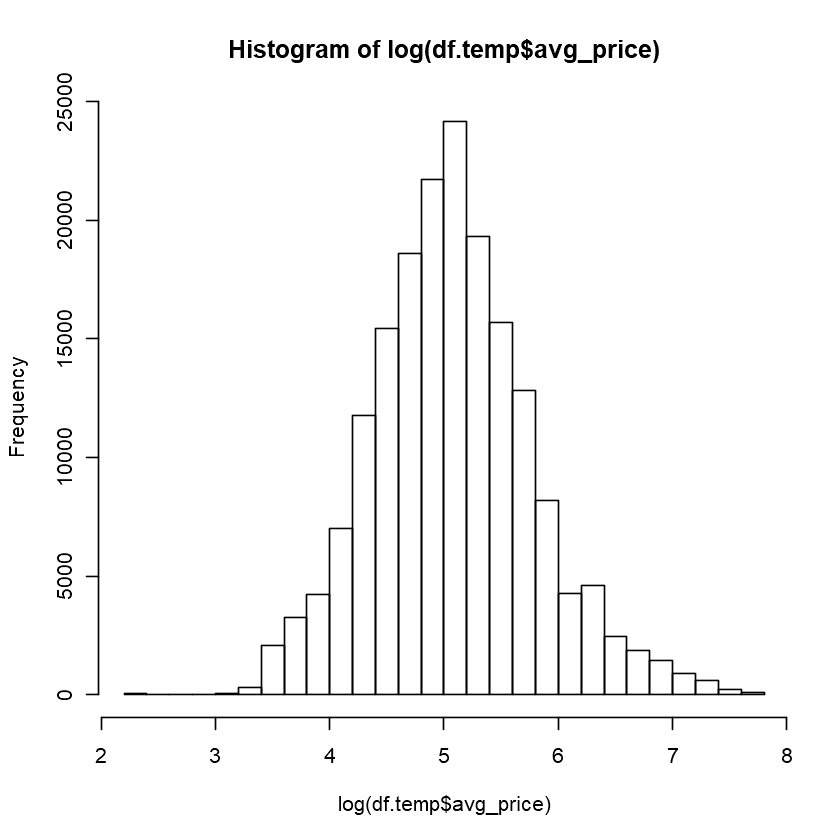

In [14]:
df.temp<-df

df.temp$avg_price[df.temp$avg_price > 2000]<-NA

summary(df.temp$avg_price)

summary(df$avg_price)

hist(log(df.temp$avg_price))

In [15]:
df$avg_price<-log(df.temp$avg_price)

## min_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0    97.0   149.0   199.5   229.0  2000.0     292 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     97.0    150.0    208.6    230.0 112010.0 

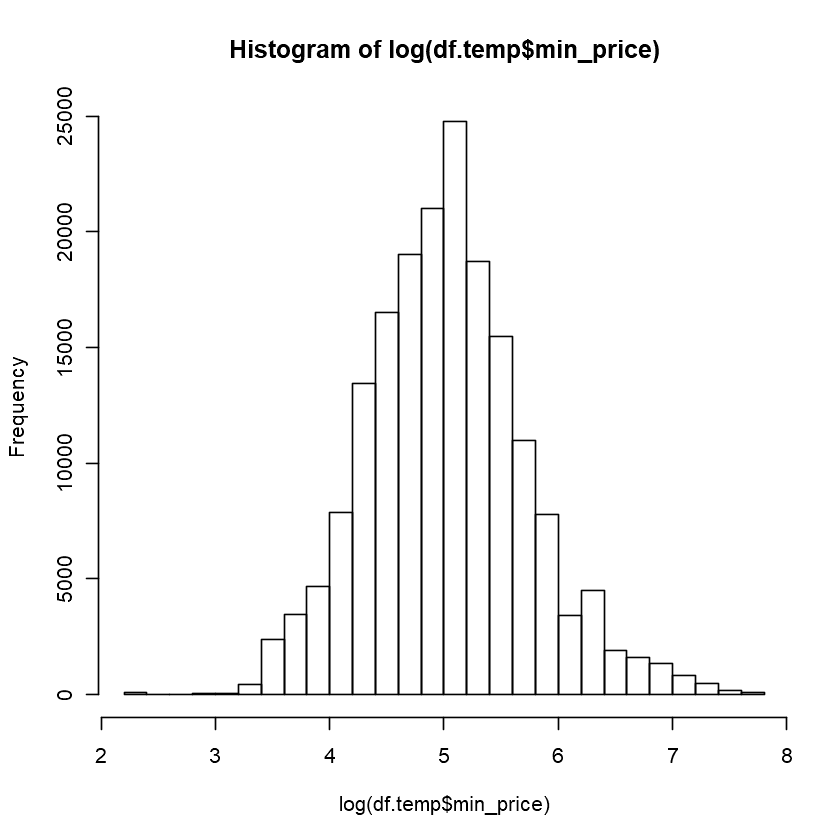

In [16]:
df.temp<-df

df.temp$min_price[df.temp$min_price > 2000]<-NA

summary(df.temp$min_price)

summary(df$min_price)

hist(log(df.temp$min_price))

In [17]:
df$min_price<-log(df.temp$min_price)

## max_price

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   10.0   105.0   160.0   223.4   256.0  2000.0     441 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0    105.0    160.0    235.5    258.0 181007.0 

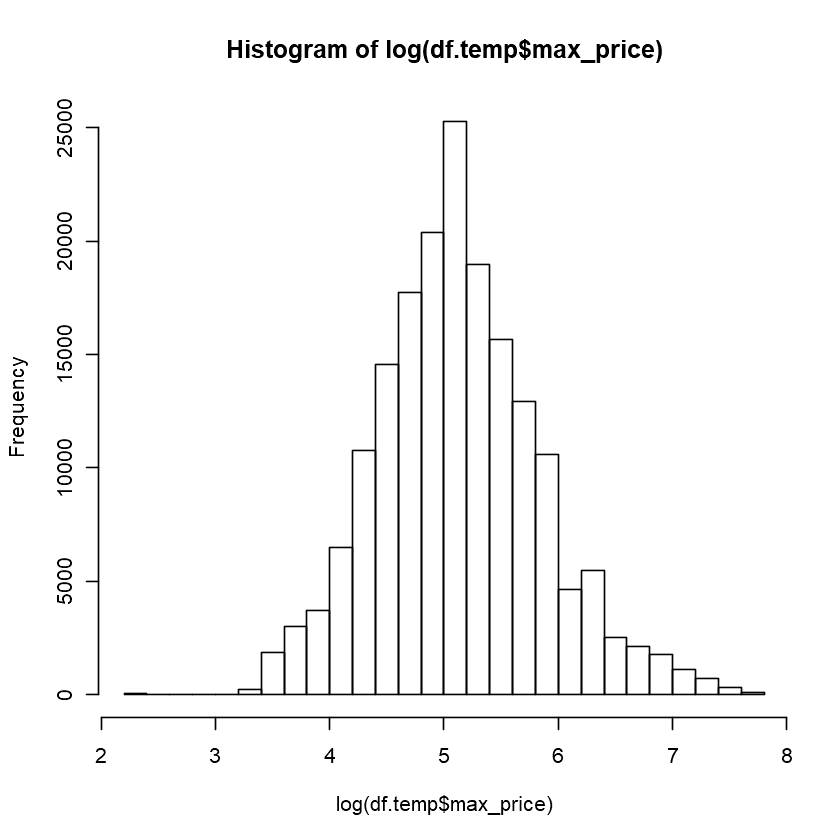

In [18]:
df.temp<-df

df.temp$max_price[df.temp$max_price > 2000]<-NA

summary(df.temp$max_price)

summary(df$max_price)

hist(log(df.temp$max_price))

In [19]:
df$max_price<-log(df$max_price)

## accommodates

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   3.158   4.000  16.000 


    1     2     3     4     5     6     7     8     9    10    11    12    13 
16055 84902 15181 36170  7410 12583  1888  3694   561  1309   211   540    16 
   14    15    16 
  216   205   527 

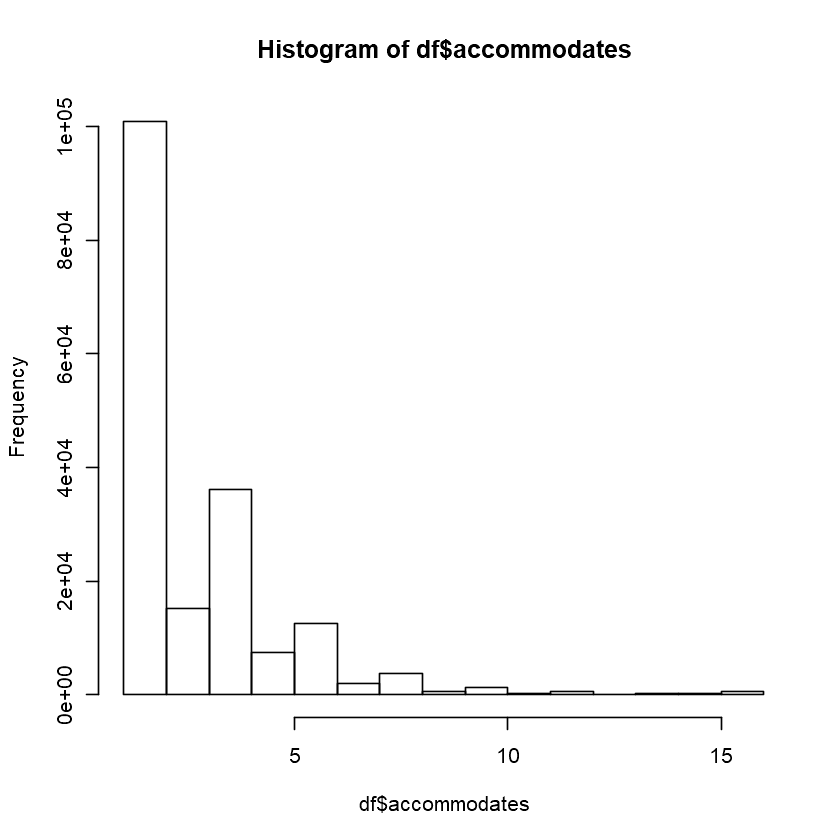

In [20]:
summary(df$accommodates)
hist(df$accommodates)

table(df$accommodates)

In [21]:
#convert into factor
df$accommodates.norm<-cut(df$accommodates, c(1,2,3,4,5,6,10000), labels = c("One", "Two", "Three", "Fore", "Five", "More"), right = FALSE)

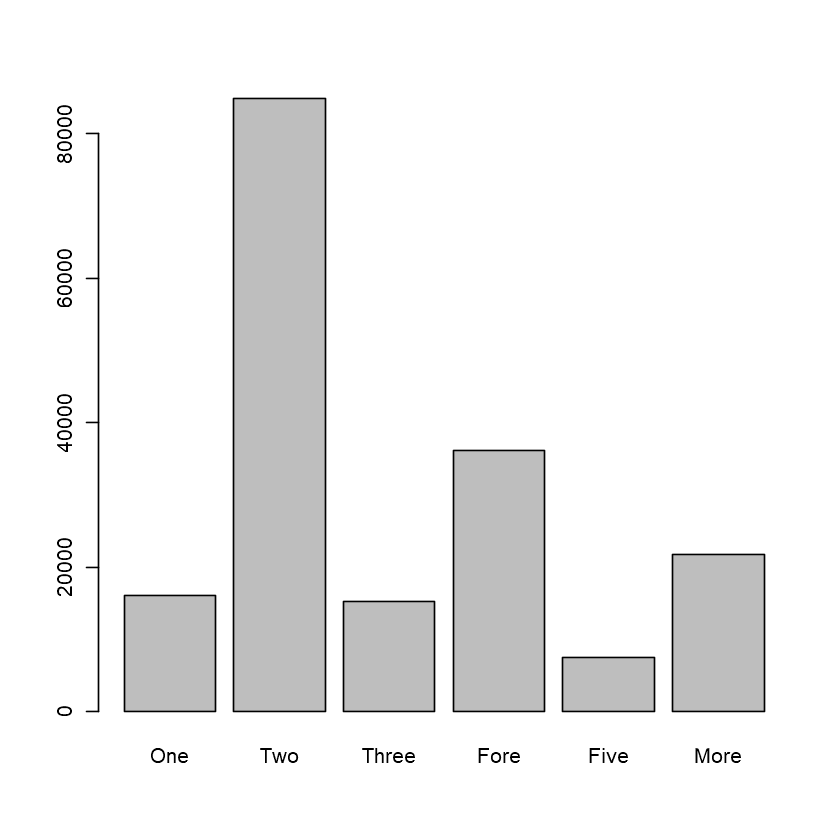

In [22]:
plot(df$accommodates.norm)

## bathrooms

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.378   1.500  15.000     639 


     0    0.5      1    1.5      2    2.5      3    3.5      4    4.5      5 
  2082    427 128574  11279  24471   4373   3467   1167   1491    220   1836 
   5.5      6      7    7.5      8     10     14     15 
    17    367    101      6    286    471     12    182 

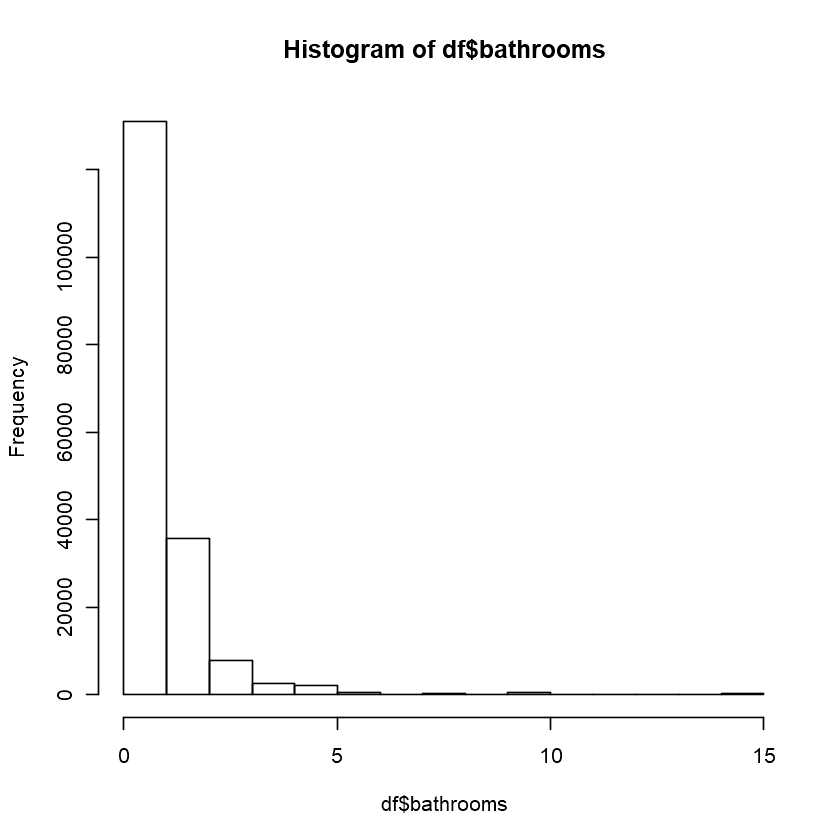

In [23]:
summary(df$bathrooms)
hist(df$bathrooms)

table(df$bathrooms)

In [24]:
#convert into factor
df$bathrooms<-cut(df$bathrooms, c(0,1,2,10000), labels = c("None", "One", "Several"), right = FALSE)


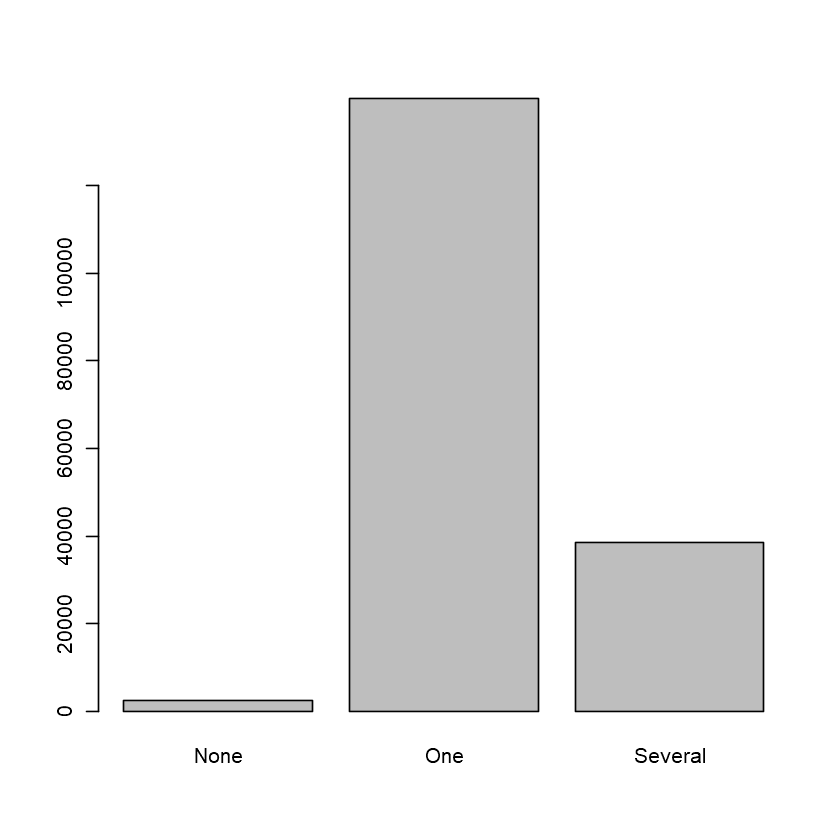

In [25]:
plot(df$bathrooms)

## bedrooms

In [26]:
summary(df$bedrooms)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.302   2.000  30.000      29 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.000   1.302   2.000  30.000      29 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.6931  0.6931  0.7661  1.0986  3.4340      29 

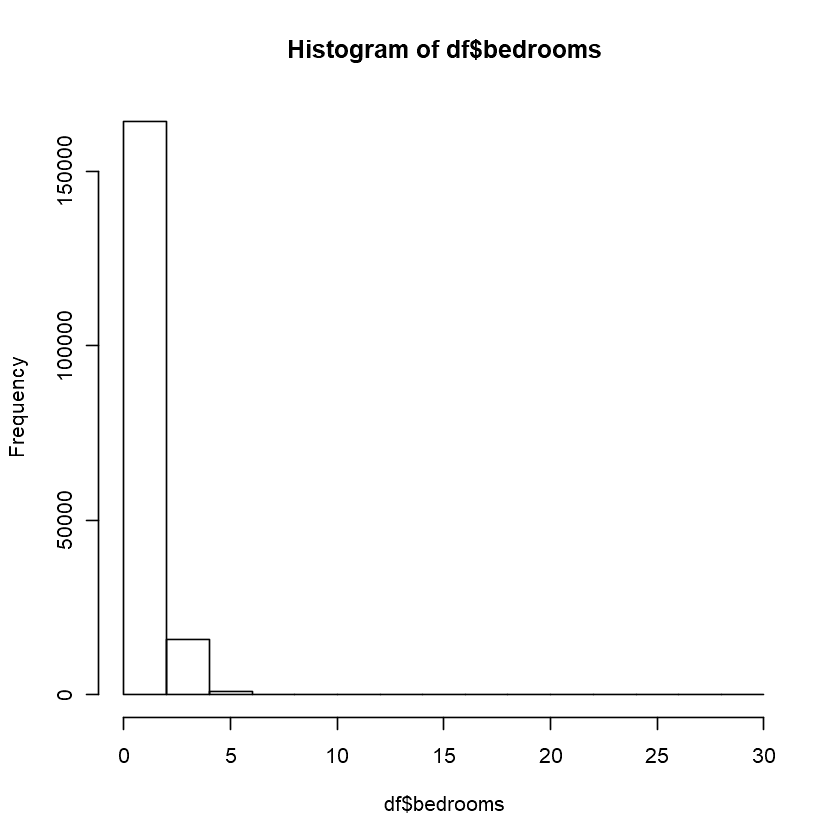

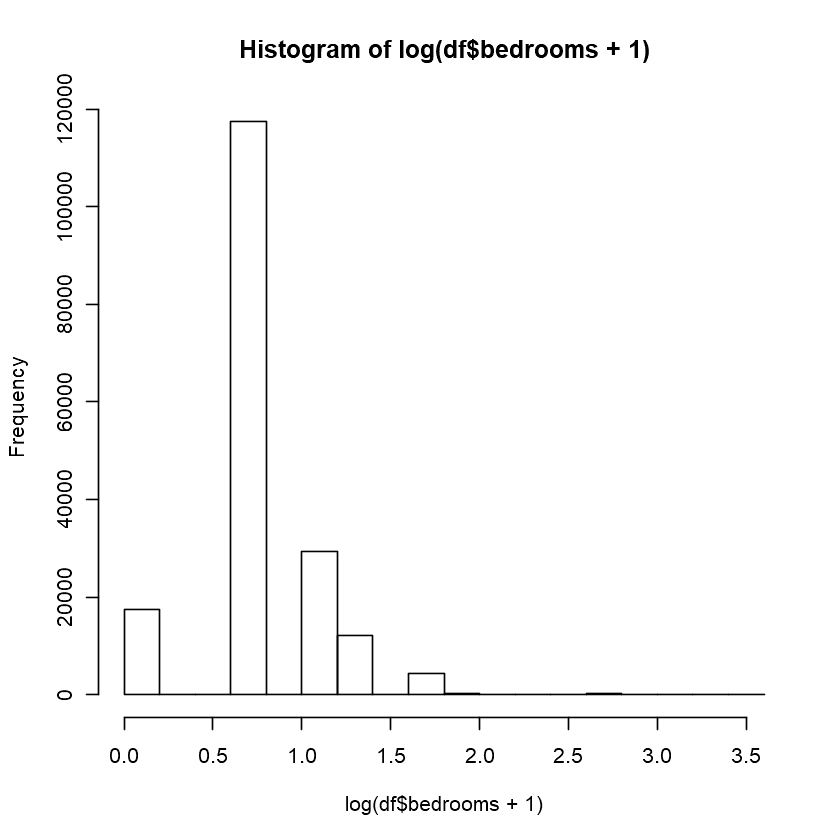

In [27]:
summary(df$bedrooms)
hist(df$bedrooms)


#check the log distribution
summary(log(df$bedrooms + 1))
hist(log(df$bedrooms + 1))

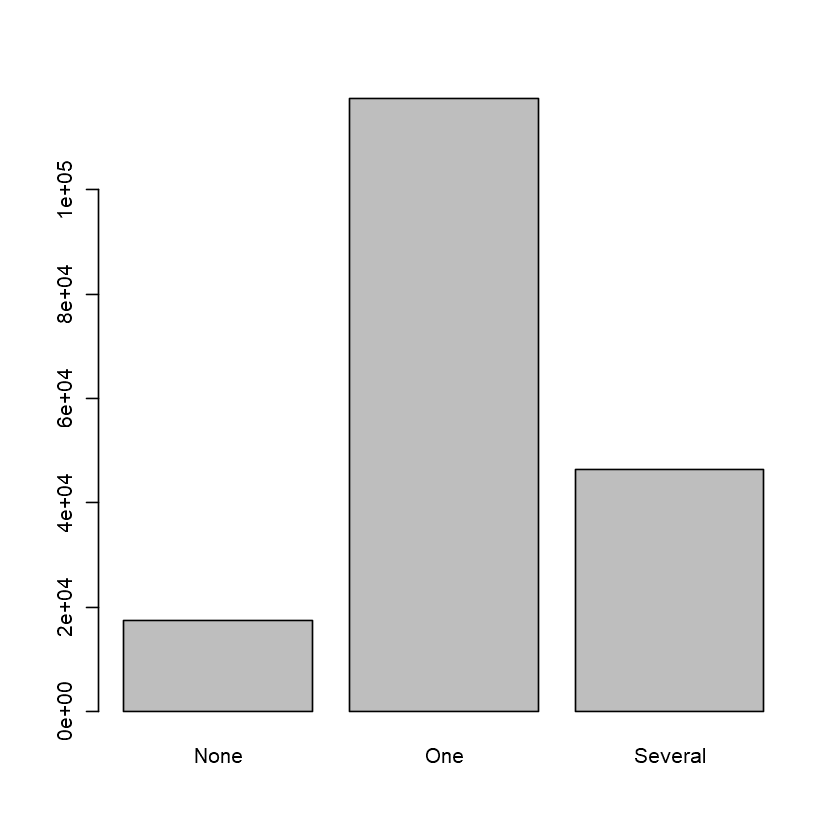

In [28]:
#convert into factor
df$bedrooms<-cut(df$bedrooms, c(0,1,2,10000), labels = c("None", "One", "Several"), right = FALSE)
plot(df$bedrooms)


## beds

In [29]:
summary(df$beds)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.768   2.000  30.000 

### Checking the outliers

In [30]:
df.test<-df[df$beds == 30,]

print(df.test[1,c('property_type', 'beds', 'bedrooms')])

       property_type beds bedrooms
16821 Boutique hotel   30  Several


### Checking the outliers (looks to be a real one, keeping it)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.768   2.000  30.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6931  0.6931  0.6931  0.9481  1.0986  3.4340 

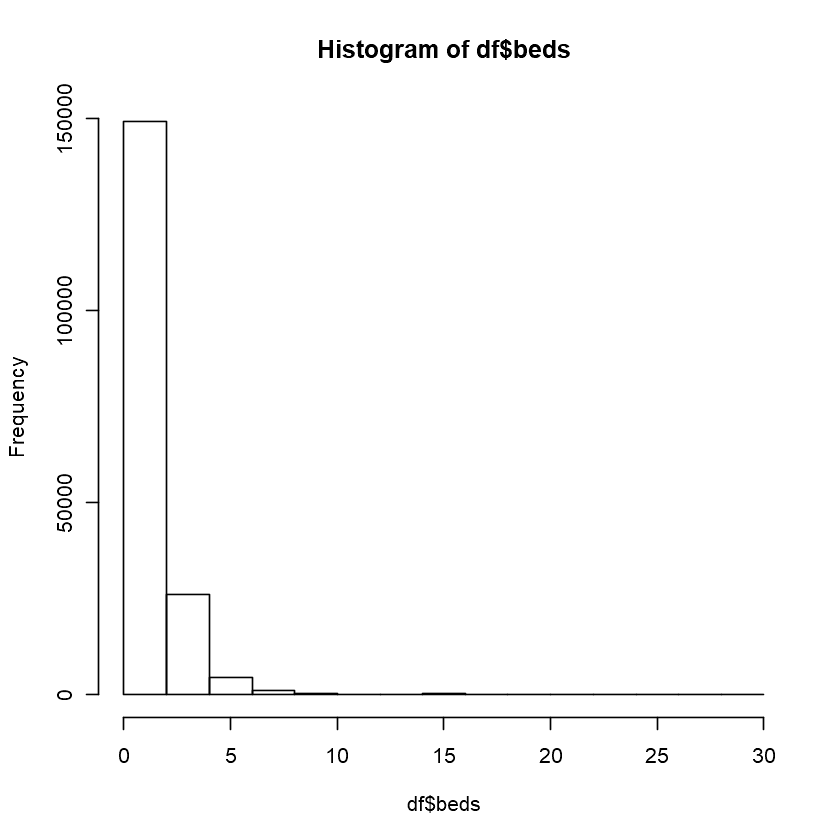

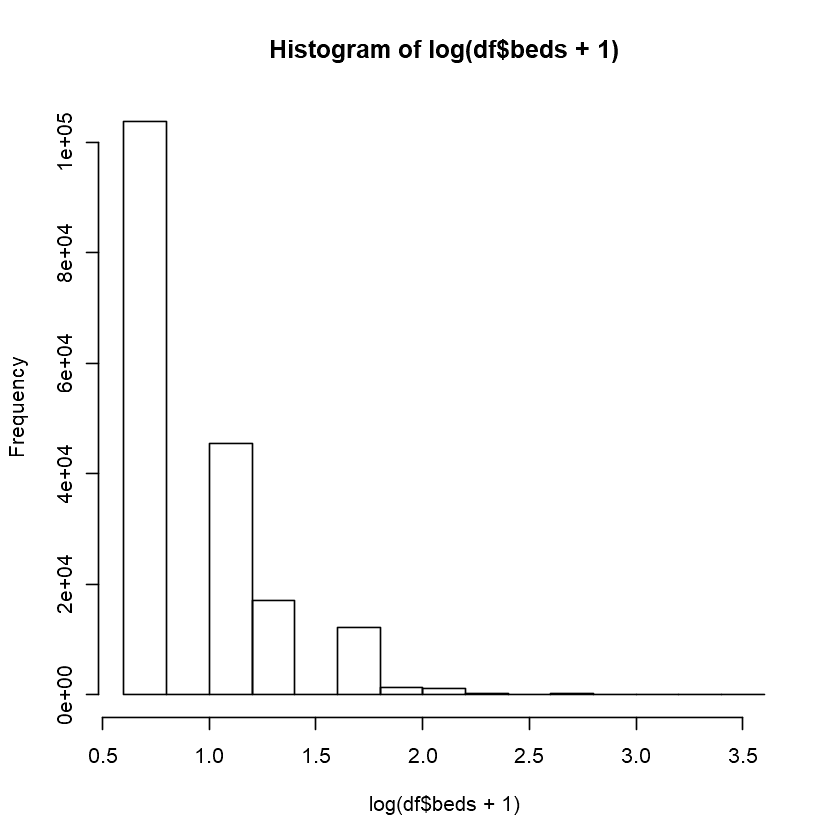

In [31]:
summary(df$beds)
hist(df$beds)


#check the log distribution
summary(log(df$beds + 1))
hist(log(df$beds + 1))

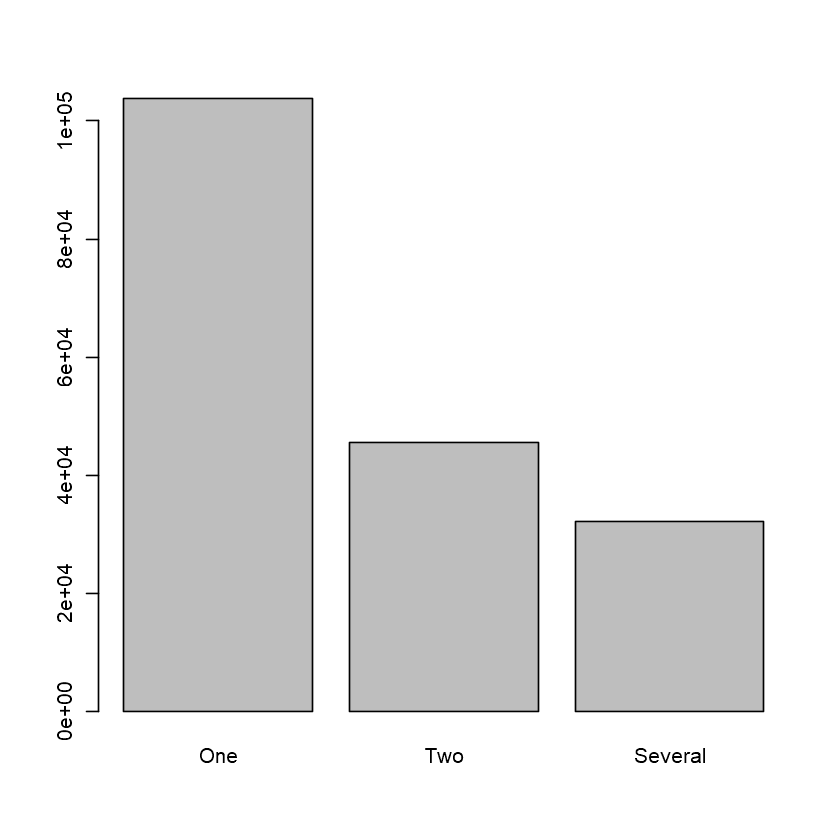

In [32]:
df$beds<-cut(df$beds, c(1,2,3,10000), labels = c("One", "Two", "Several"), right = FALSE)

plot(df$beds)

## security_deposit

In [33]:
summary(df$security_deposit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0   100.0   307.9   500.0  5150.0 

In [34]:
### Checking the outliers

In [35]:
df.test<-df[df$security_deposit > 500,]

print(df.test[c('security_deposit', 'property_type', 'beds', 'bedrooms', 'calculated_host_listings_count')])

       security_deposit      property_type    beds bedrooms
5                  2500          Apartment     One     None
6                  2500          Apartment     One     None
22                  750              House Several  Several
44                 1500              House Several  Several
52                 2500        Condominium     Two  Several
54                 5000              House Several  Several
55                 5000              House Several  Several
67                 3000          Apartment     Two  Several
68                 3000          Apartment     Two  Several
78                 2000              House Several  Several
79                 2000              House Several  Several
80                 5000               Loft     One      One
81                 5000               Loft     One      One
82                 5000               Loft     One      One
83                 5000               Loft     One      One
99                 1000          Townhou

### Looks real (keeping the values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0   100.0   307.9   500.0  5150.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   4.615   3.189   6.217   8.547 

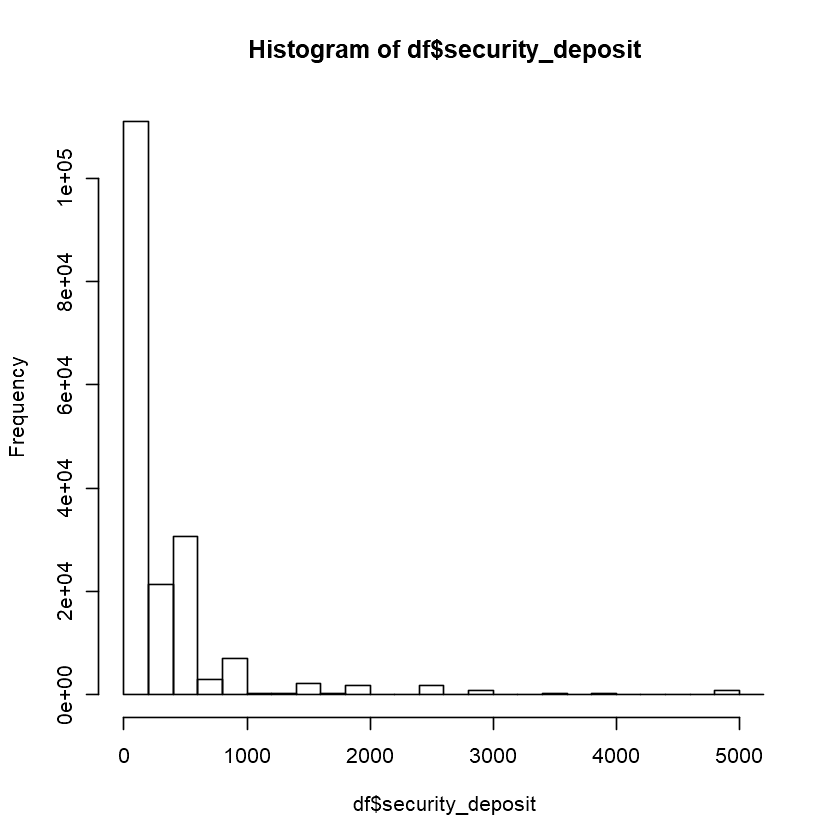

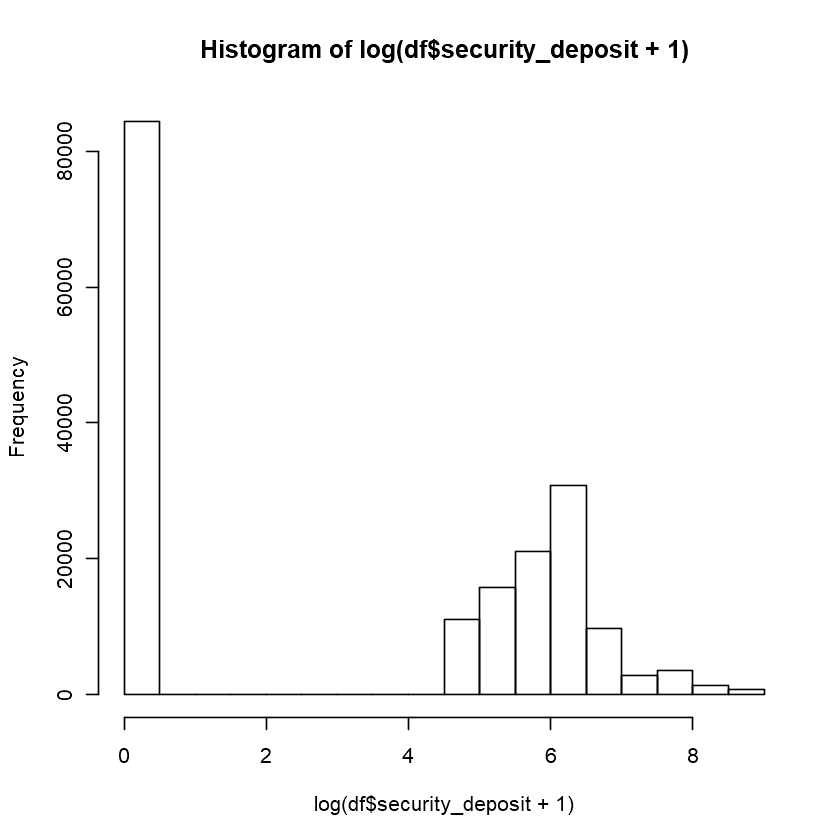

In [36]:
summary(df$security_deposit)
hist(df$security_deposit)


#check the log distribution
summary(log(df$security_deposit + 1))
hist(log(df$security_deposit + 1))

In [37]:
# better convert into factor
df$security_deposit<-cut(df$security_deposit, c(0,1,500,1000, 10000), labels = c("None", "S", "M", "L"), right = FALSE)

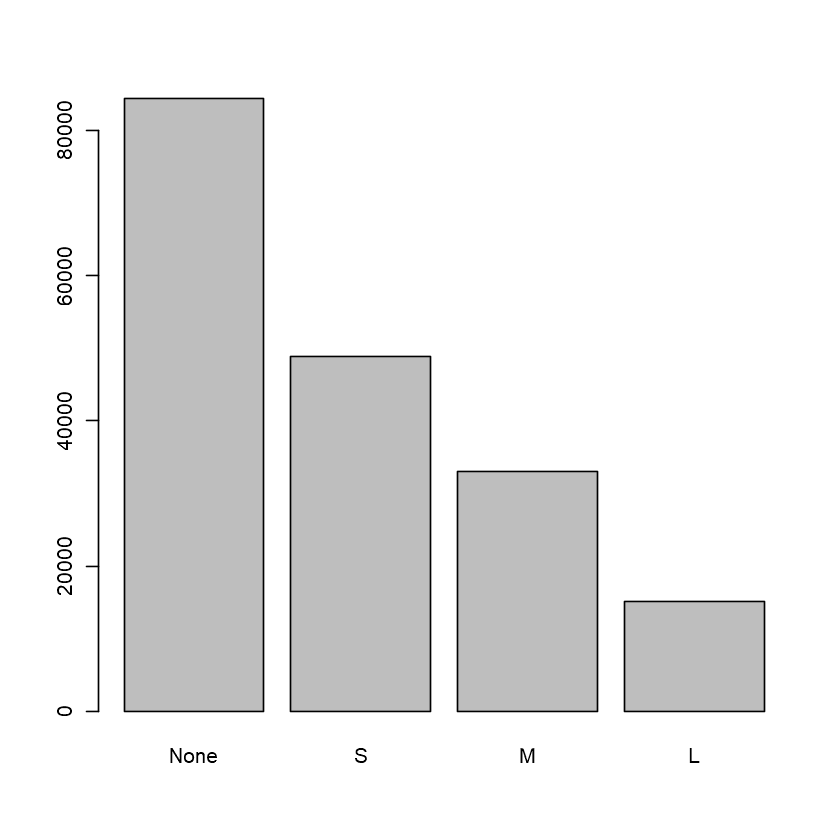

In [38]:
plot(df$security_deposit)

## cleaning_fee

In [39]:
summary(df$cleaning_fee)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   30.00   70.00   84.73  120.00 1500.00 

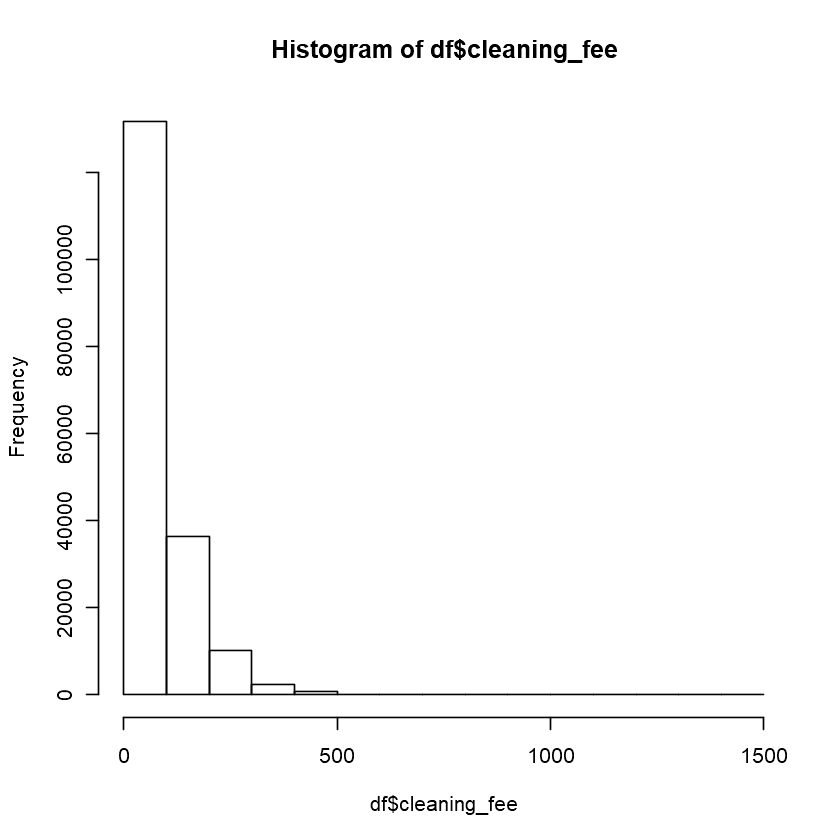

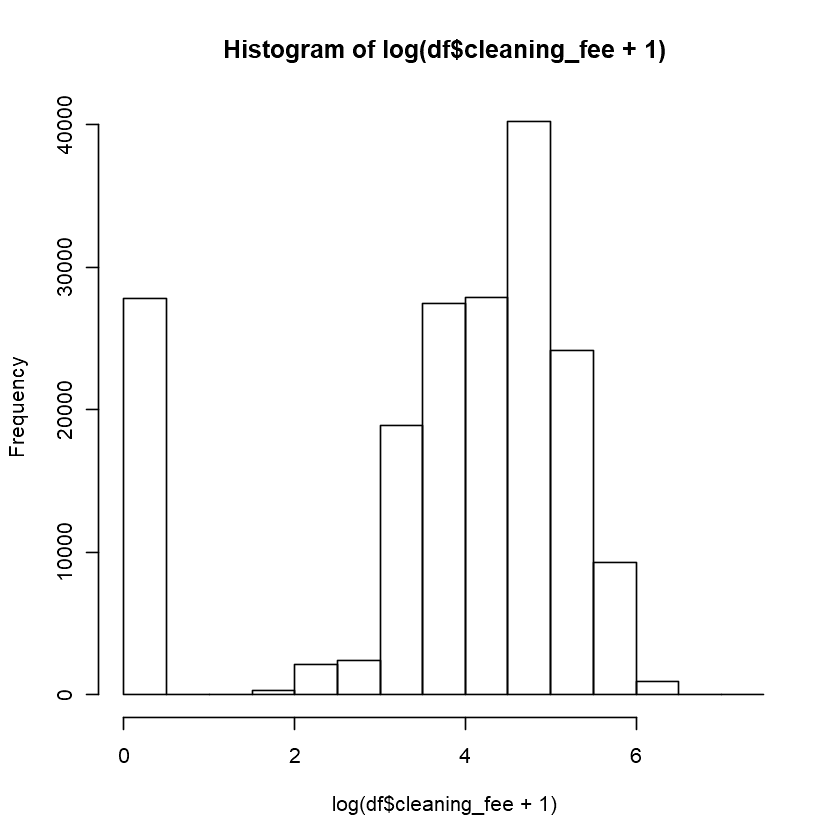

In [40]:
hist(df$cleaning_fee)

hist(log(df$cleaning_fee + 1))

In [41]:
# convertin into factor
df$cleaning_fee<-cut(df$cleaning_fee, c(0,1,50,100, 200, 2000), labels = c("None", "S", "M", "L", "XL"), right = FALSE)

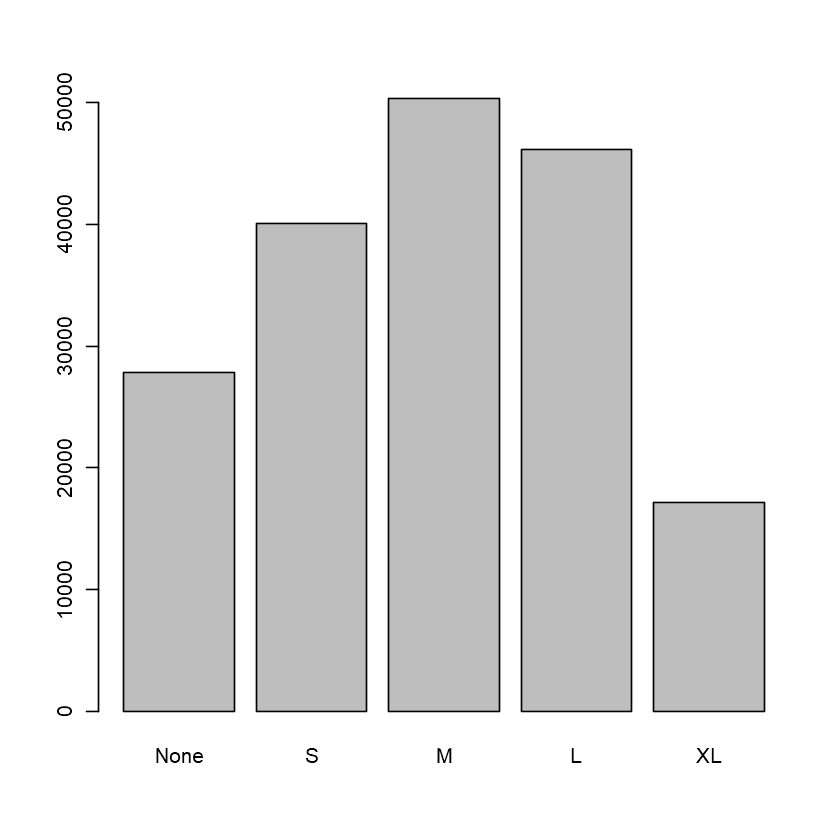

In [42]:
plot(df$cleaning_fee)

## guests_included

In [43]:
summary(df$guests_included)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00    1.71    2.00   30.00 


     0      1      2      3      4      5      6      7      8      9     10 
   588 113220  43275   4450  12562   1857   3738    357    877    136    267 
    11     12     15     16     30 
     3     95      5     35      3 

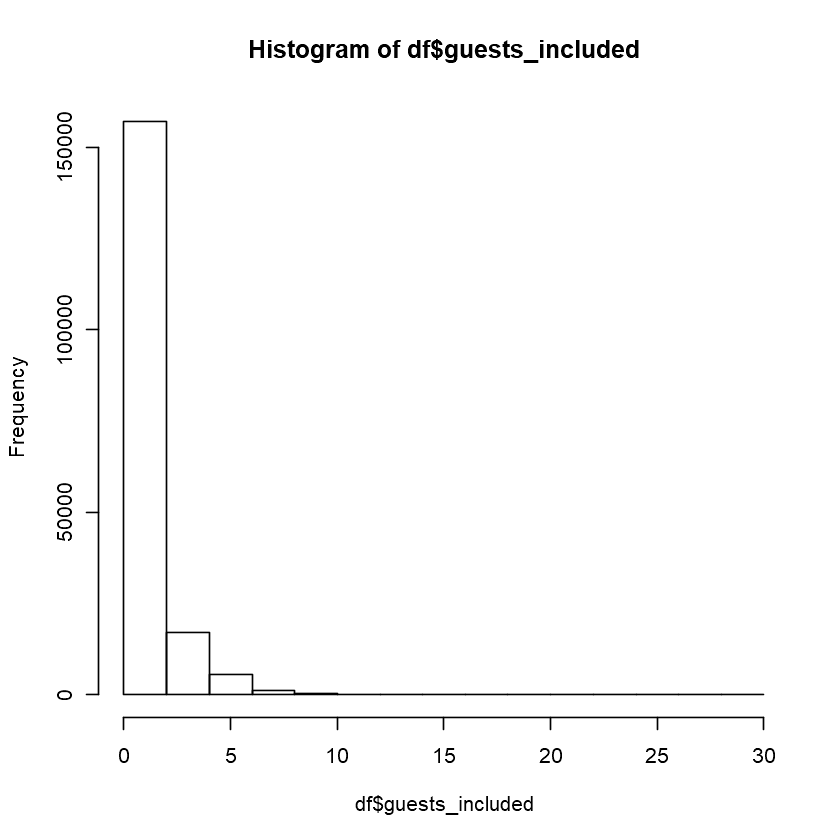

In [44]:
hist(df$guests_included)

table(df$guests_included)

In [45]:
# convertin into factor


df$guests_included<-cut(df$guests_included, c(0,2,3,7, 31), labels = c("upTwo", "upThree", "upSeven", "More"), right = FALSE)

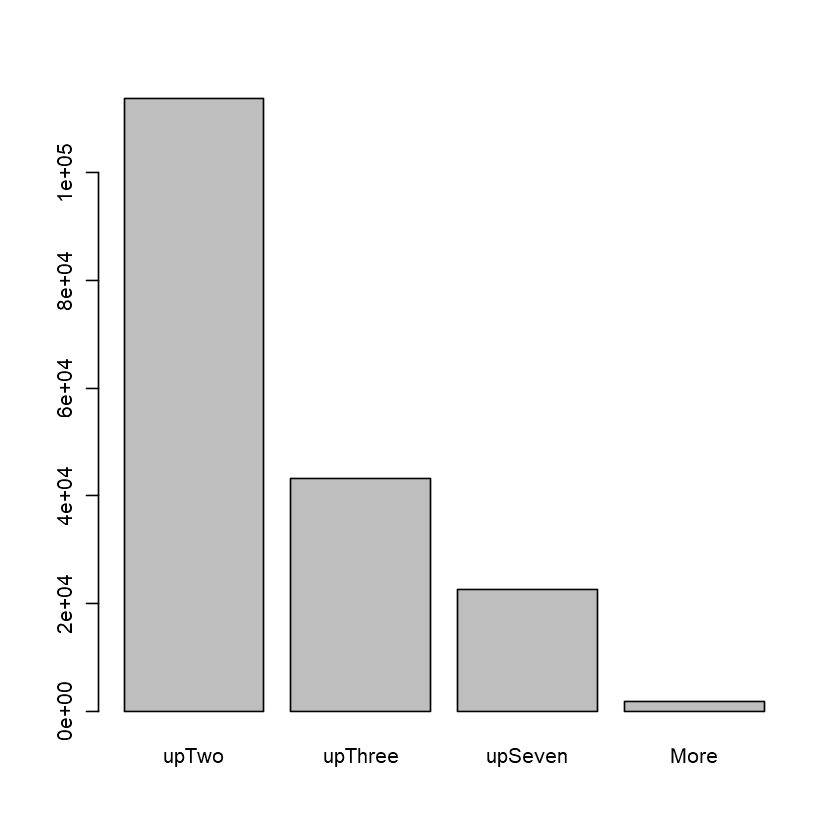

In [46]:
plot(df$guests_included)

## extra_people

In [47]:
summary(df$extra_people)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    5.00   17.37   25.00  300.00 


    0     5     6     7     8     9    10    11    12    13    14    15    16 
90611  8149    51   669   348    85  5878    95   522    28    34  6139    59 
   17    18    19    20    21    22    23    24    25    26    27    28    29 
   12   378   629 12154    27    84    32    75 15742    22    73    81   520 
   30    31    32    33    34    35    36    37    38    39    40    41    42 
 5063    54   171   234    70  3433    65    50   145   321  3927    19   245 
   43    44    45    46    47    48    49    50    51    52    55    56    57 
   40    43  2515    28    41    38   319 11870     5   108   504     6    20 
   58    59    60    62    63    65    68    69    70    71    72    73    75 
   27    84   805     1     8   392    17    96   299     8     5     5  1746 
   79    80    85    86    88    89    90    95    99   100   104   105   110 
   75   405    73     3     2    16   192   173   379  2944     2     3    31 
  115   119   120   123   124   125   130   135   1

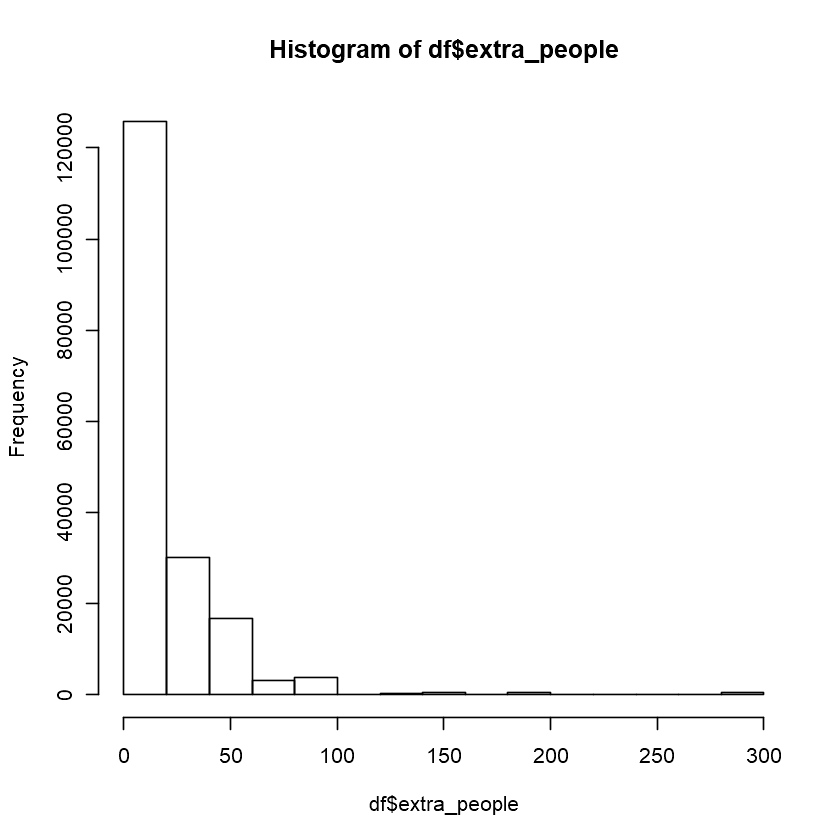

In [48]:
hist(df$extra_people)

table(df$extra_people)

In [49]:
# convertin into factor
df$extra_people<-cut(df$extra_people, c(0,1,50, 100, 400), labels = c("None", "Fifty", "Hundred", "More"), right = FALSE)

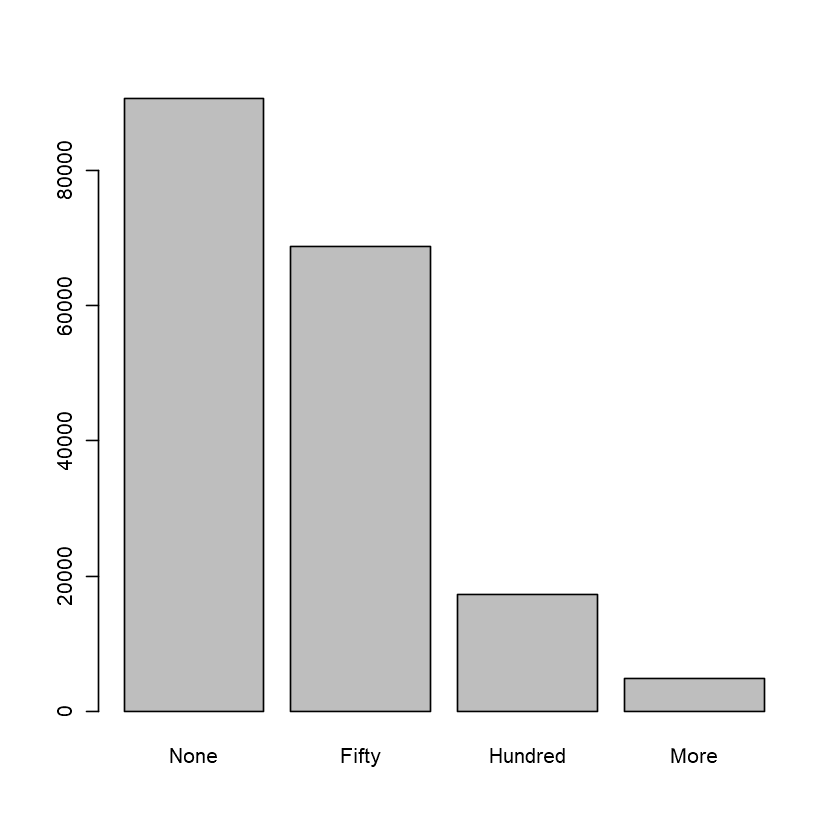

In [50]:
plot(df$extra_people)

## minimum_nights

In [51]:
summary(df$minimum_nights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00   11.09   30.00  365.00 


    1     2     3     4     5     6     7     8     9    10    11    12    13 
48985 42341 21888  6186  4129   777  2037    33    27   200    22    37    21 
   14    15    16    17    18    19    20    21    22    23    24    25    27 
  266    63     5     3   108     3    54   113     4     1     9    53    38 
   28    29    30    31    32    33    35    38    40    42    45    46    50 
  110   125 50767  1239   494     5     3     5    15     3    36     5     5 
   54    55    57    58    59    60    70    80    85    89    90    92   110 
    3     4     4     3    13   451    11    22     8     4   271     1     1 
  120   150   180   182   183   185   190   256   298   300   302   360   365 
   27     5   346     9     6    10     2     2     5     2     2    15    26 

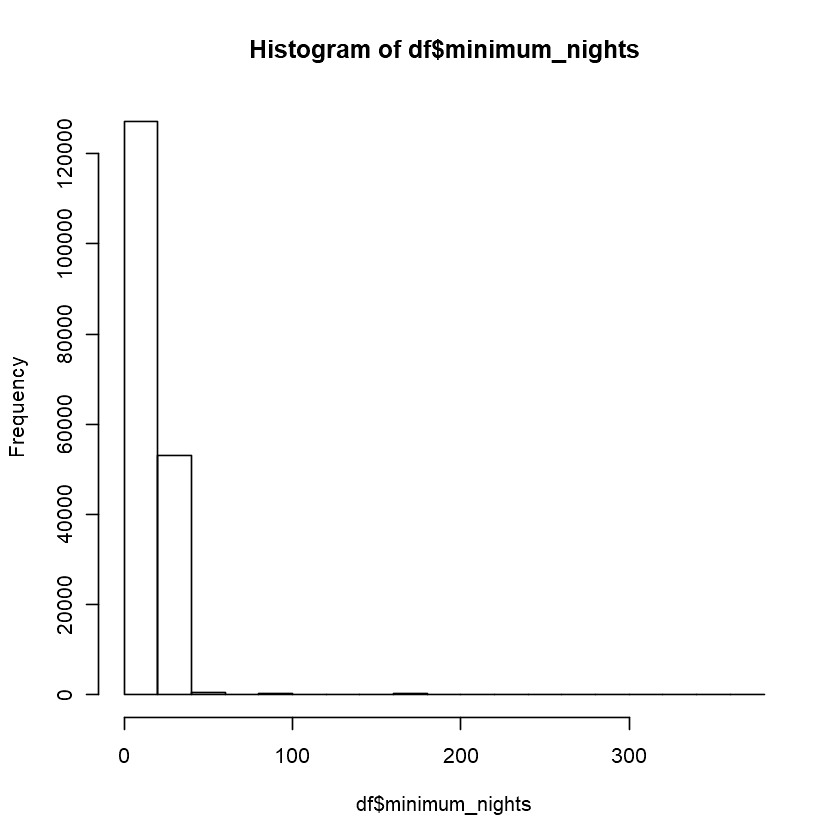

In [52]:
hist(df$minimum_nights)

table(df$minimum_nights)

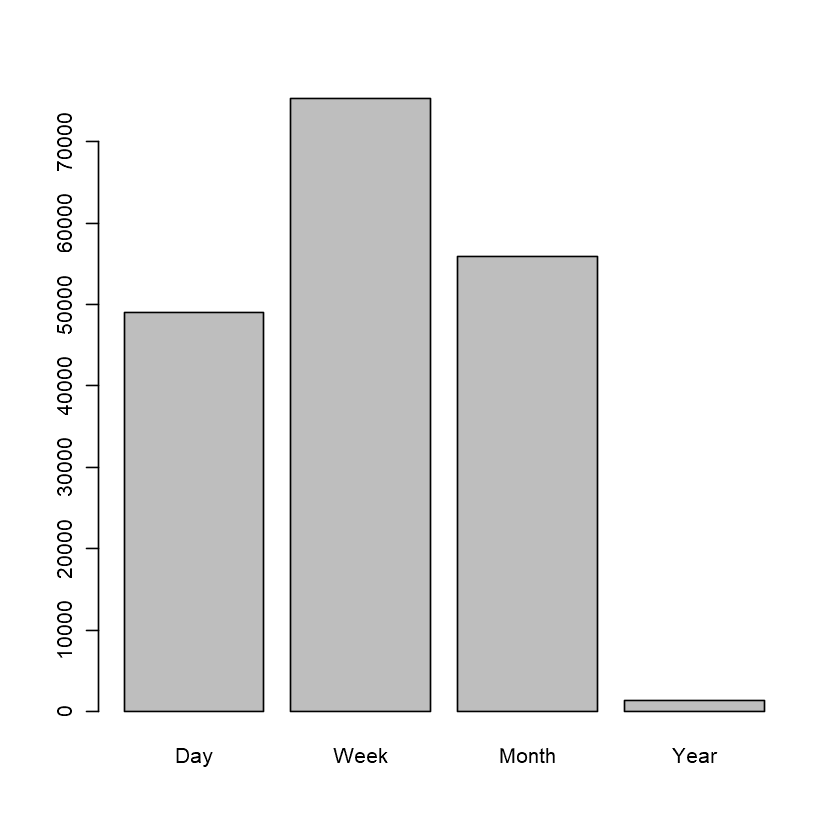

In [53]:
# convertin into factor
df$minimum_nights<-cut(df$minimum_nights, c(1,2,7, 35, 400), labels = c("Day", "Week", "Month", "Year"), right = FALSE)
plot(df$minimum_nights)

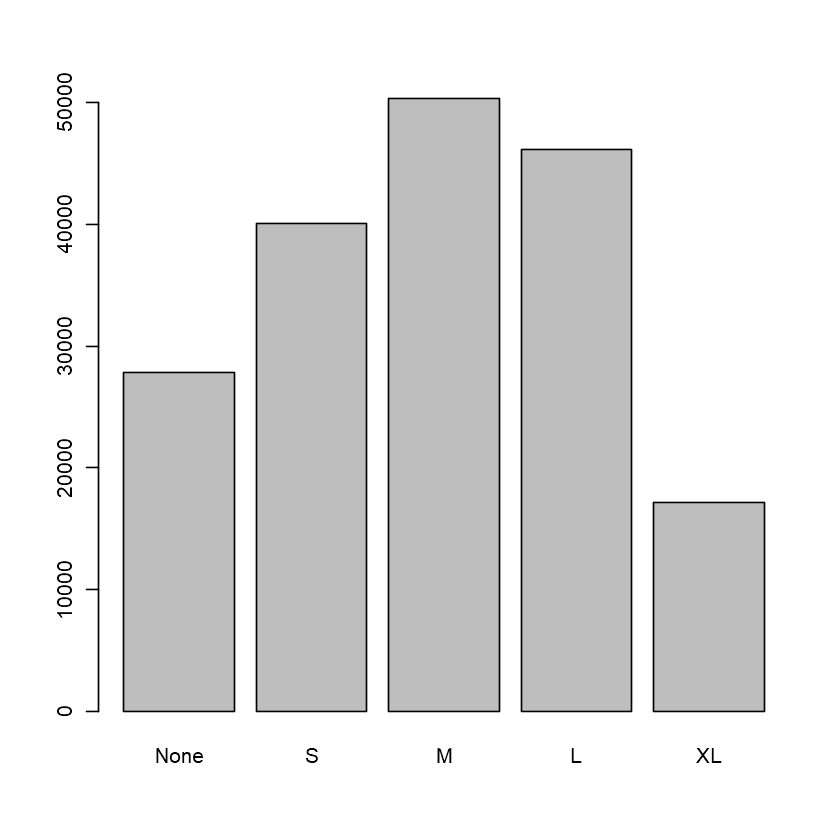

In [54]:
plot(df$cleaning_fee)

## maximum_nights

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e+00 2.800e+01 1.820e+02 1.545e+05 1.125e+03 2.147e+09 


        79        390        760       1116       1121       1500         41 
         1          1          1          1          1          1          2 
        49         51         58        115        118        142        143 
         2          2          2          2          2          2          2 
       178        225        301        355        404        540        256 
         2          2          2          2          2          2          3 
       258        265        352        465       1110         48         56 
         3          3          3          3          3          4          4 
        78         84         94        122        299        345         43 
         4          4          4          4          4          4          5 
        67         68        102        105        107        248        302 
         5          5          5          5          5          5          5 
       420        799       1094       3090       5000         

[1] 181468     50

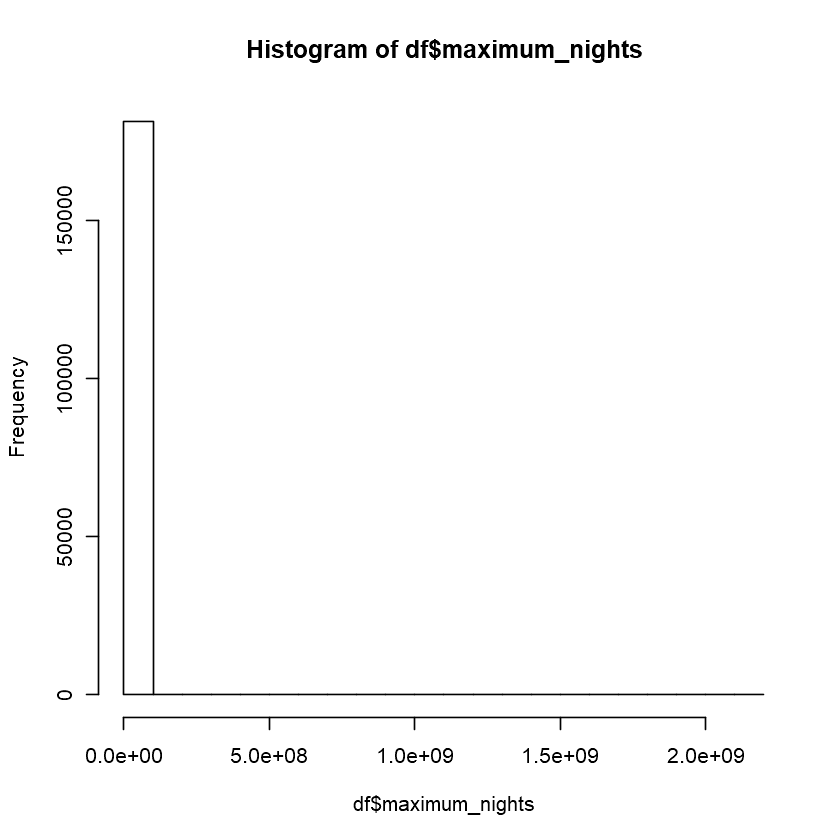

In [55]:
summary(df$maximum_nights)
hist(df$maximum_nights)
sort(table(df$maximum_nights))
dim(df)

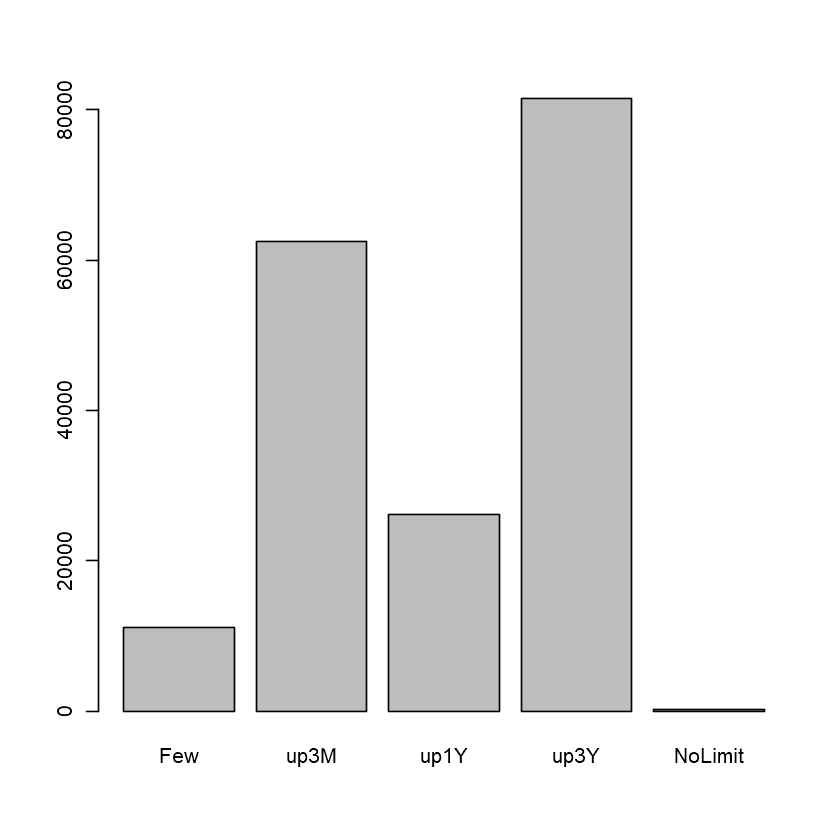

In [56]:
df$maximum_nights<-cut(df$maximum_nights, c(0,10,90,366,1130, 10000), labels = c("Few", "up3M", "up1Y", "up3Y", "NoLimit" ), right = FALSE)

plot(df$maximum_nights)

## number_of_reviews

In [57]:
summary(df$number_of_reviews)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00   12.00   44.37   54.00  771.00 

### Looking into Max value

In [58]:
df[df$number_of_reviews == 771,]

,X,listing_id,week_num,avg_price,min_price,max_price,host_is_superhost,host_identity_verified,neighbourhood_cleansed,zipcode,...,occupied_cat,summary,space,description,neighborhood_overview,notes,transit,host_about,amenities,accommodates.norm
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
57950,90427,545685,52,4.521789,4.369448,4.663439,t,f,Outer Richmond,94121,...,Medium,"New renovated Garden Suite with separated entrance, private Living room, private Bathroom","Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richmond, San Francisco which is close to the Golden Gate Bridge and Golden Gate Park. It is a","New renovated Garden Suite with separated entrance, private Living room, private Bathroom Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richm",,,,We have been living in San Francisco over than10 years. We like the city very much. You will like it too!,"{TV,Wifi,Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation m",Two
57951,90428,545685,53,4.704369,4.488636,4.804021,t,f,Outer Richmond,94121,...,Medium,"New renovated Garden Suite with separated entrance, private Living room, private Bathroom","Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richmond, San Francisco which is close to the Golden Gate Bridge and Golden Gate Park. It is a","New renovated Garden Suite with separated entrance, private Living room, private Bathroom Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richm",,,,We have been living in San Francisco over than10 years. We like the city very much. You will like it too!,"{TV,Wifi,Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation m",Two
57952,90431,545685,50,4.644391,4.488636,4.736198,t,f,Outer Richmond,94121,...,Full,"New renovated Garden Suite with separated entrance, private Living room, private Bathroom","Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richmond, San Francisco which is close to the Golden Gate Bridge and Golden Gate Park. It is a","New renovated Garden Suite with separated entrance, private Living room, private Bathroom Newly renovated Garden Suite with separated entrance, private living room, bed room, bathroom. You have total privacy during your stay. Our house is in Central Richm",,,,We have been living in San Francisco over than10 years. We like the city very much. You will like it too!,"{TV,Wifi,Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation m",Two


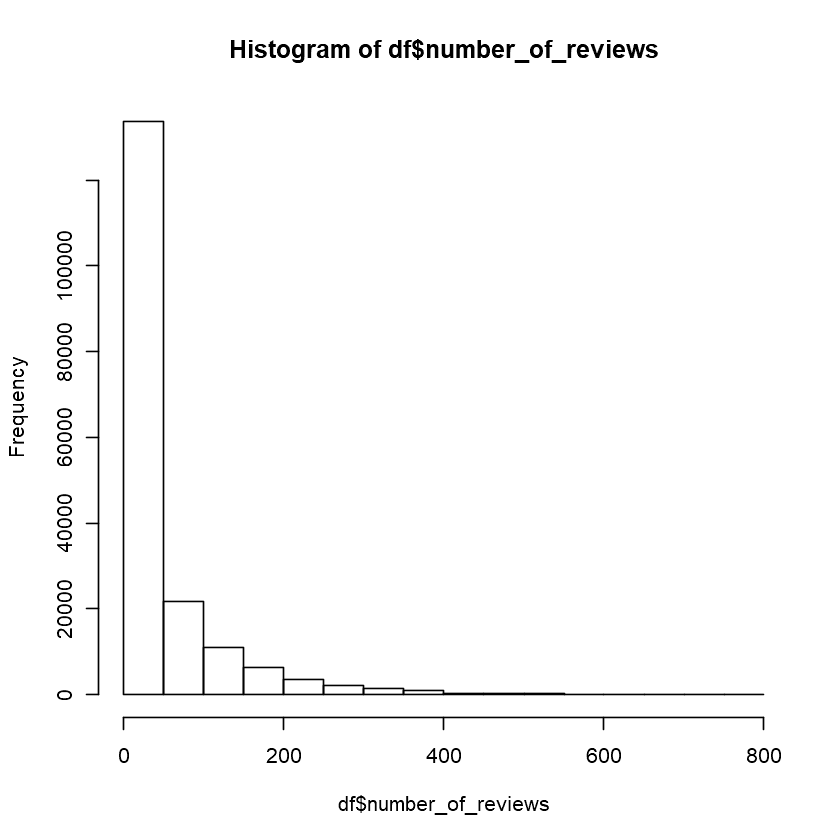

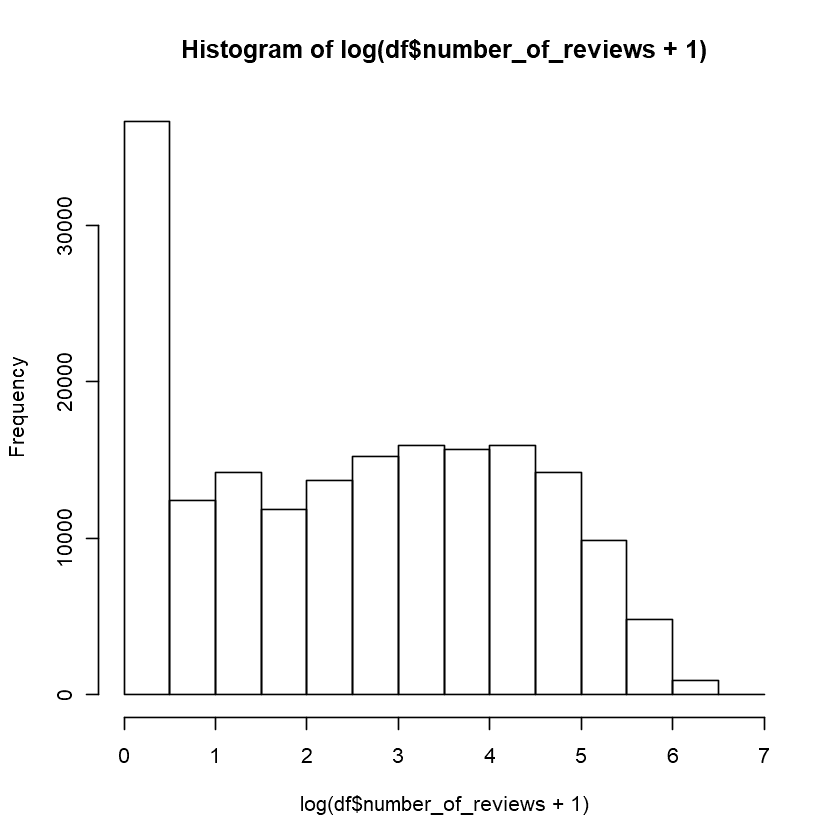

In [59]:
hist(df$number_of_reviews)

hist(log(df$number_of_reviews + 1))

In [60]:
# convertin into factor

df$number_of_reviews<-cut(df$number_of_reviews, c(0,1,50, 150, 1000), labels = c("None", "S", "M", "L"), right = FALSE)

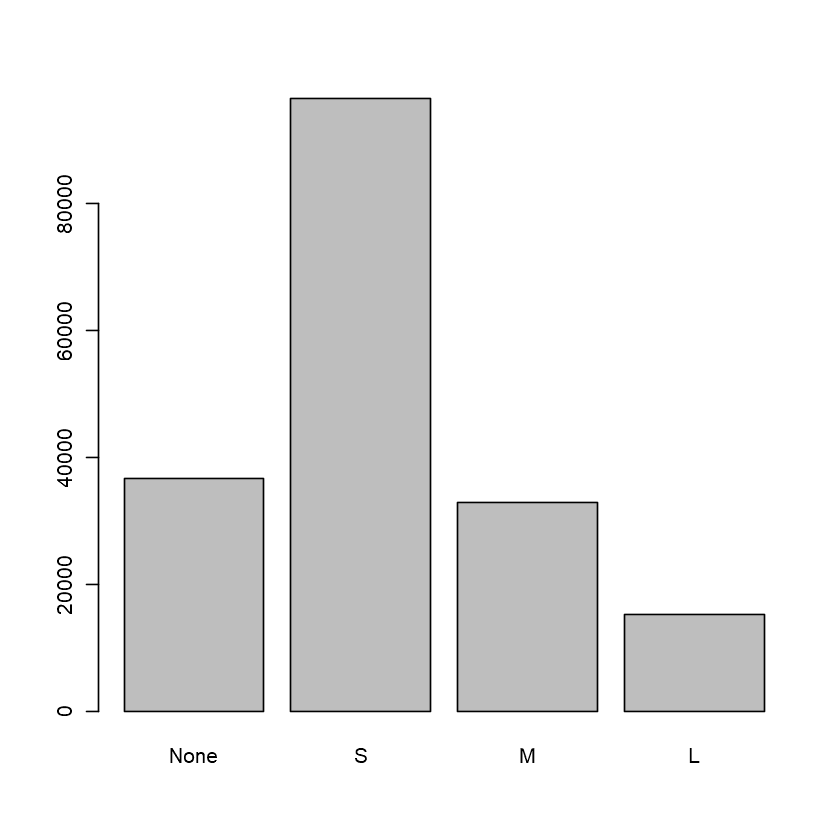

In [61]:
plot(df$number_of_reviews)

## review_scores_accuracy

In [62]:
summary(df$review_scores_accuracy)
dim(df)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    2.0    10.0    10.0     9.7    10.0    10.0   37472 

[1] 181468     50

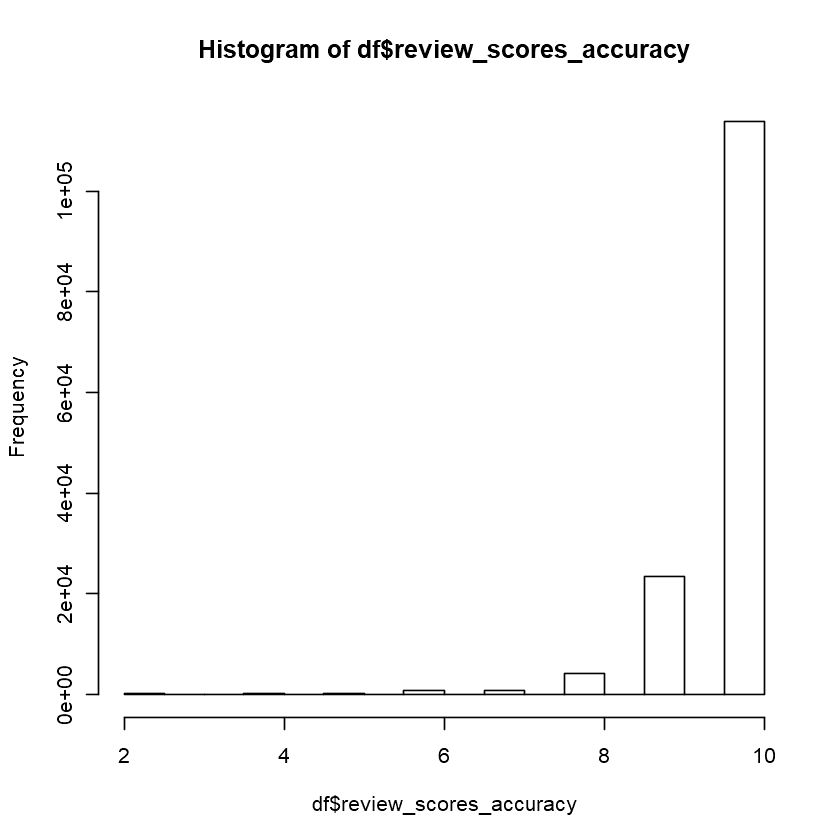

In [63]:
hist(df$review_scores_accuracy)

In [64]:
# replace missing values by 11
df$review_scores_accuracy[is.na(df$review_scores_accuracy)] <- 11

# create a factors
df$review_scores_accuracy<-cut(df$review_scores_accuracy, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

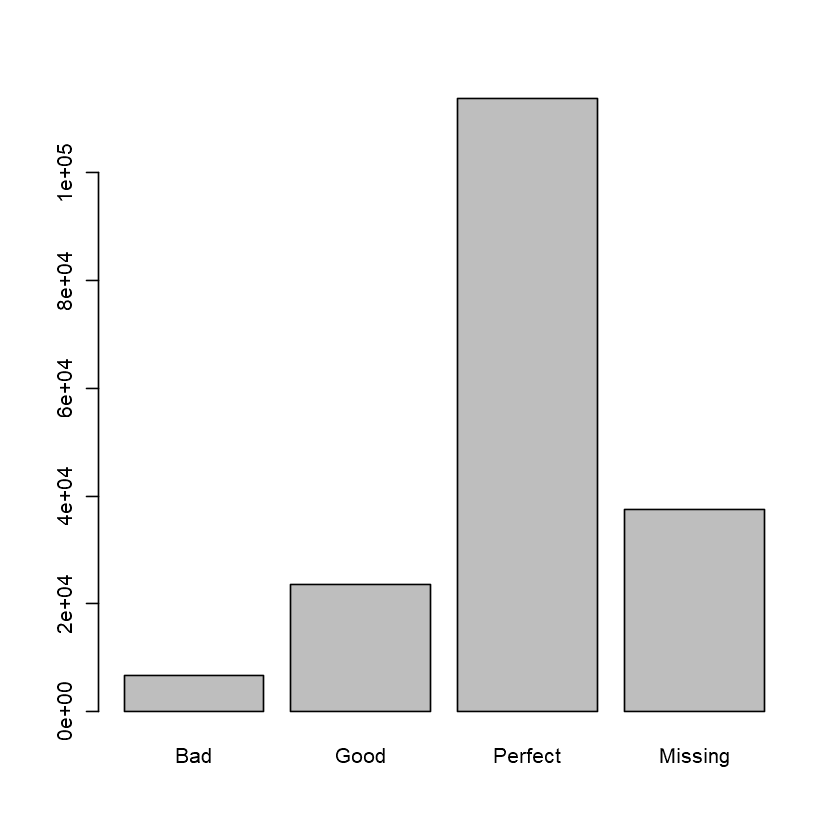

In [65]:
plot(df$review_scores_accuracy)

## review_scores_cleanliness

In [66]:
summary(df$review_scores_cleanliness)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.00   10.00    9.57   10.00   10.00   37479 

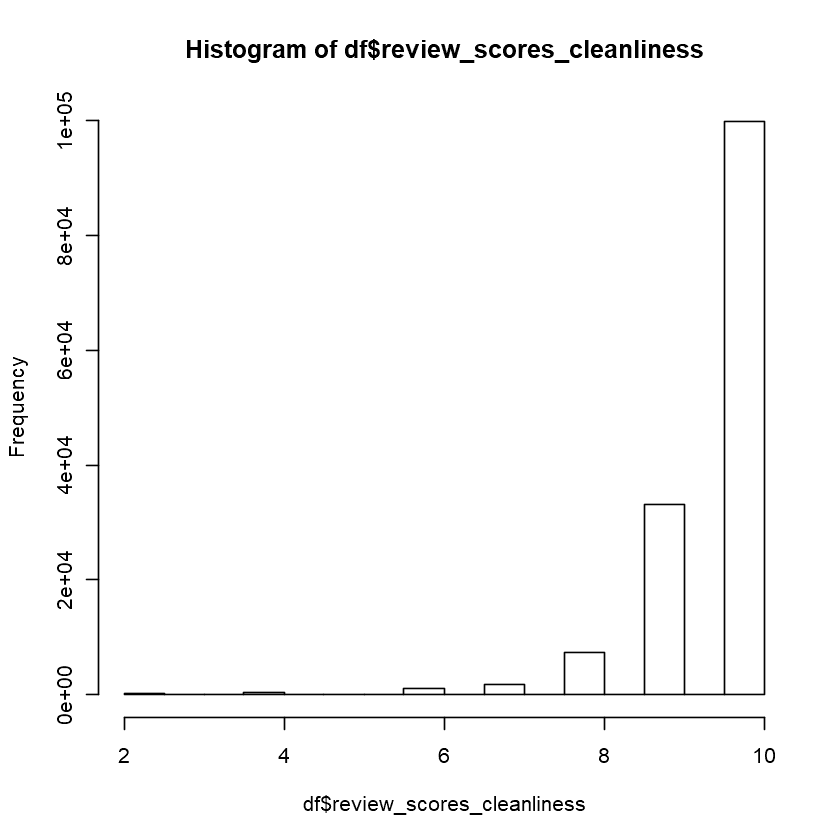

In [67]:
hist(df$review_scores_cleanliness)

In [68]:
# replace missing values by 11
df$review_scores_cleanliness[is.na(df$review_scores_cleanliness)] <- 11

# create a factors
df$review_scores_cleanliness<-cut(df$review_scores_cleanliness, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

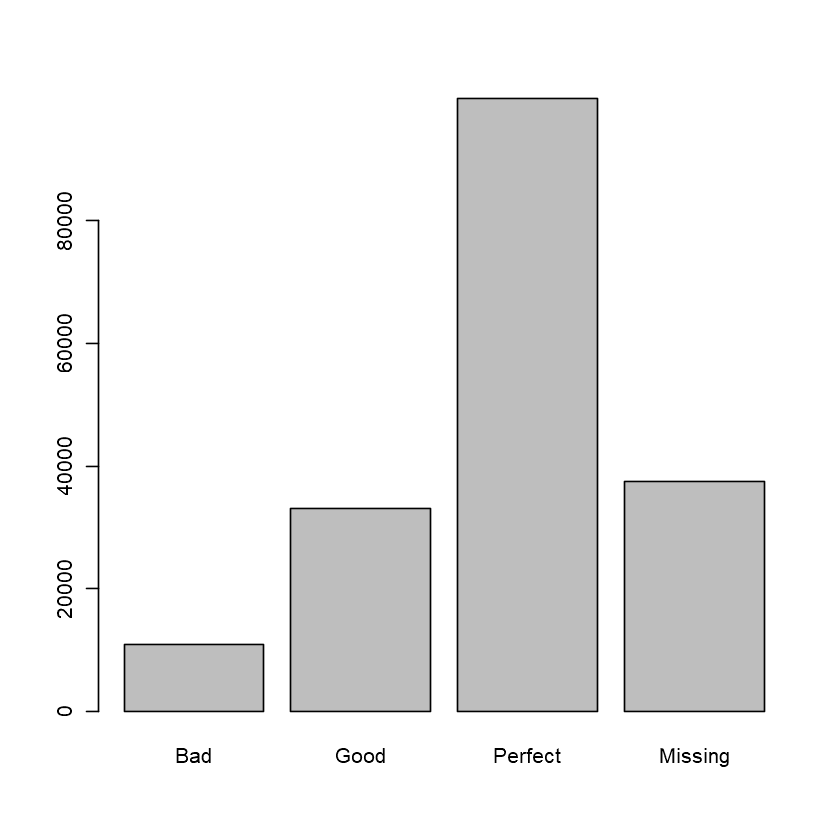

In [69]:
plot(df$review_scores_cleanliness)

## review_scores_checkin

In [70]:
summary(df$review_scores_checkin)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00   10.00   10.00    9.82   10.00   10.00   37511 

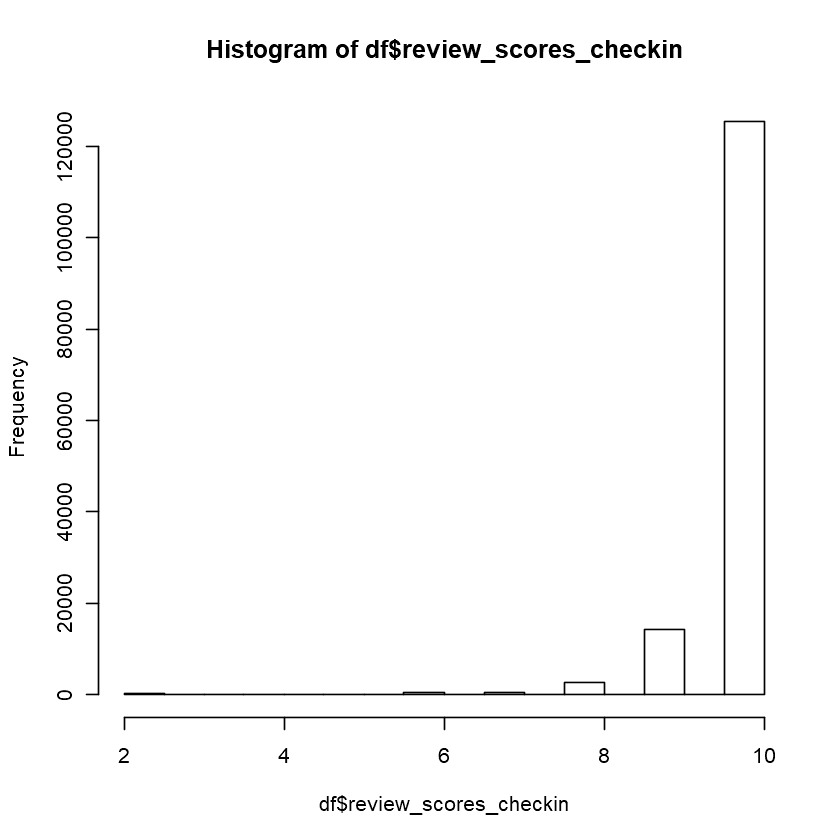

In [71]:
hist(df$review_scores_checkin)

In [72]:
# replace missing values by 11
df$review_scores_checkin[is.na(df$review_scores_checkin)] <- 11

# create a factors
df$review_scores_checkin<-cut(df$review_scores_checkin, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

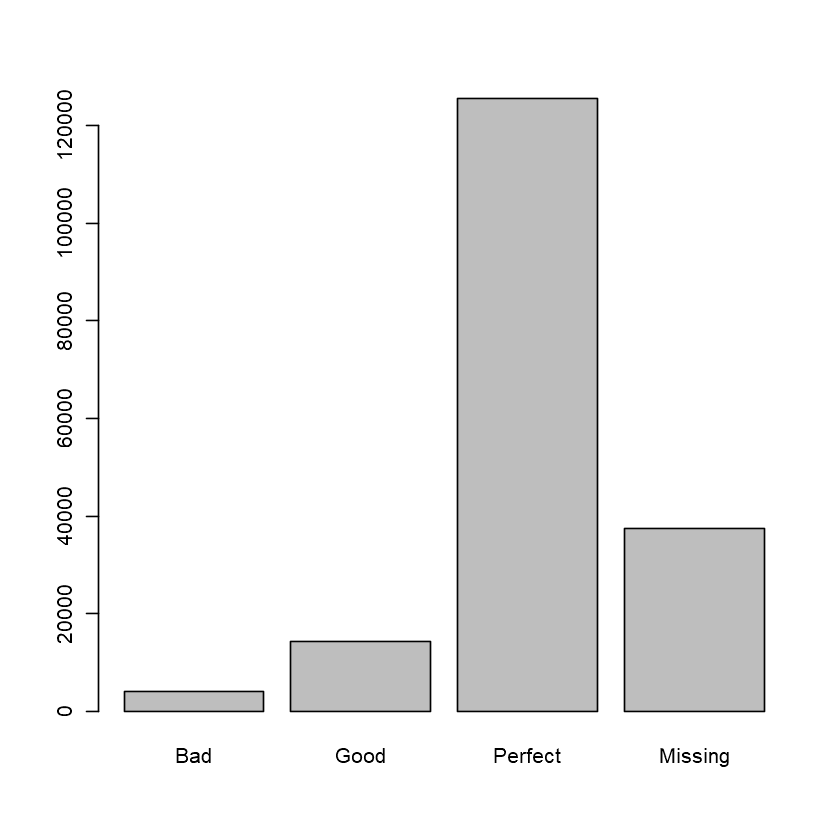

In [73]:
plot(df$review_scores_checkin)

## review_scores_communication

In [74]:
summary(df$review_scores_communication)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    2.0    10.0    10.0     9.8    10.0    10.0   37471 

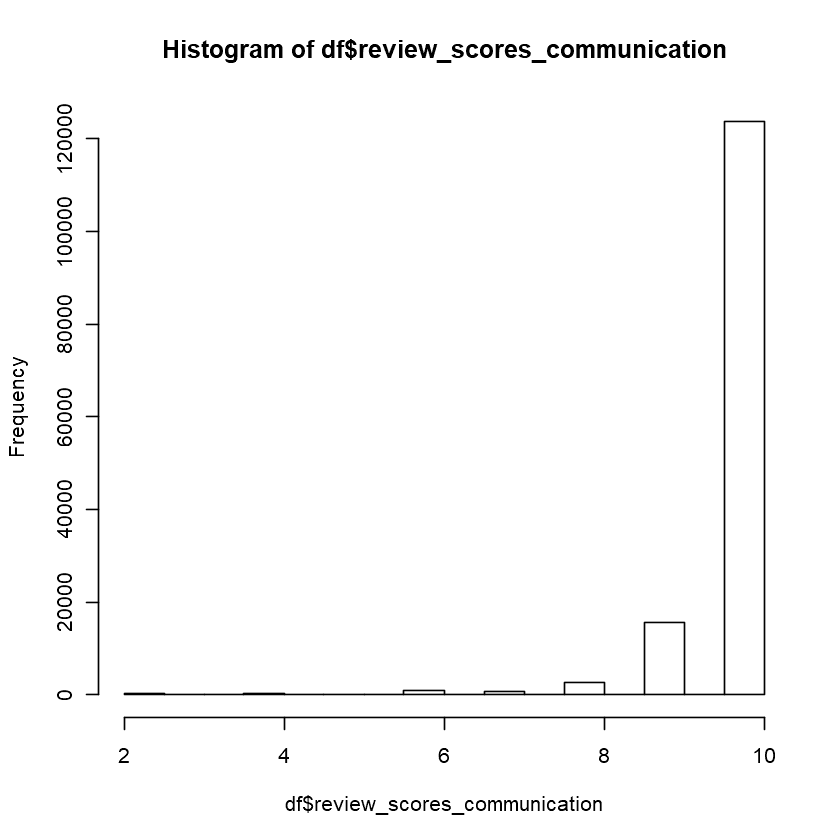

In [75]:
hist(df$review_scores_communication)

In [76]:
# replace missing values by 11
df$review_scores_communication[is.na(df$review_scores_communication)] <- 11

# create a factors
df$review_scores_communication<-cut(df$review_scores_communication, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

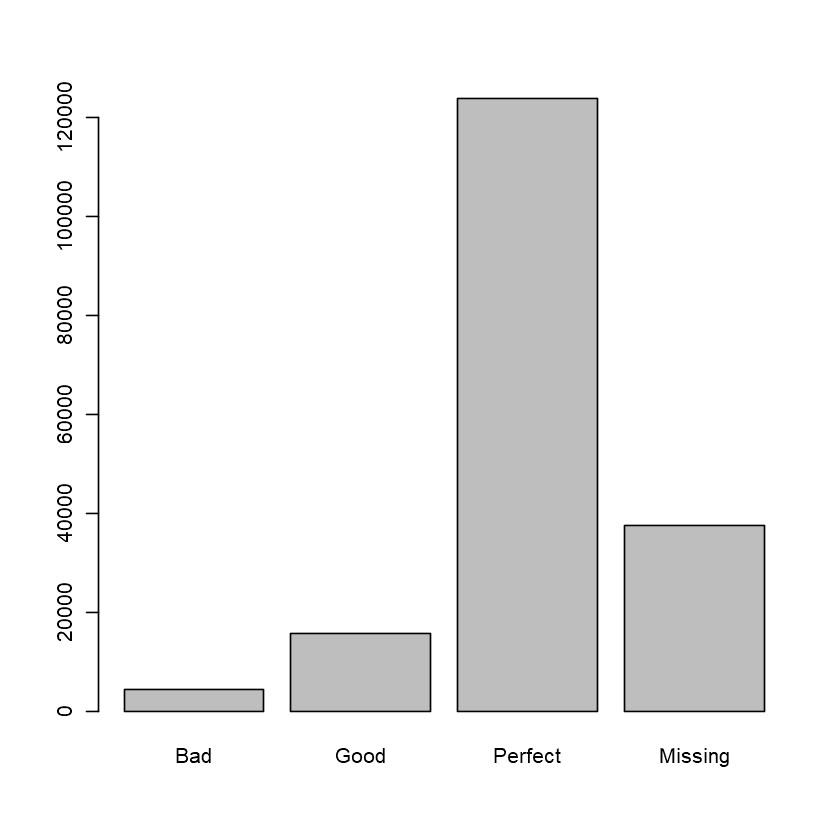

In [77]:
plot(df$review_scores_communication)

## review_scores_location

In [78]:
summary(df$review_scores_location)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.00   10.00    9.63   10.00   10.00   37509 

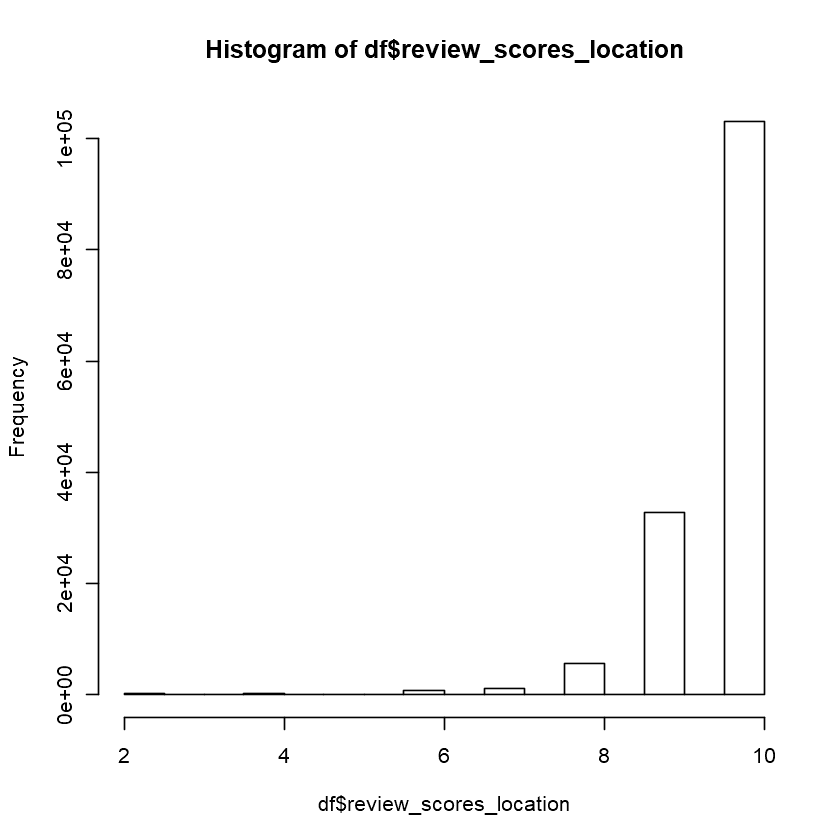

In [79]:
hist(df$review_scores_location)

In [80]:
# replace missing values by 11
df$review_scores_location[is.na(df$review_scores_location)] <- 11

# create a factors
df$review_scores_location<-cut(df$review_scores_location, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

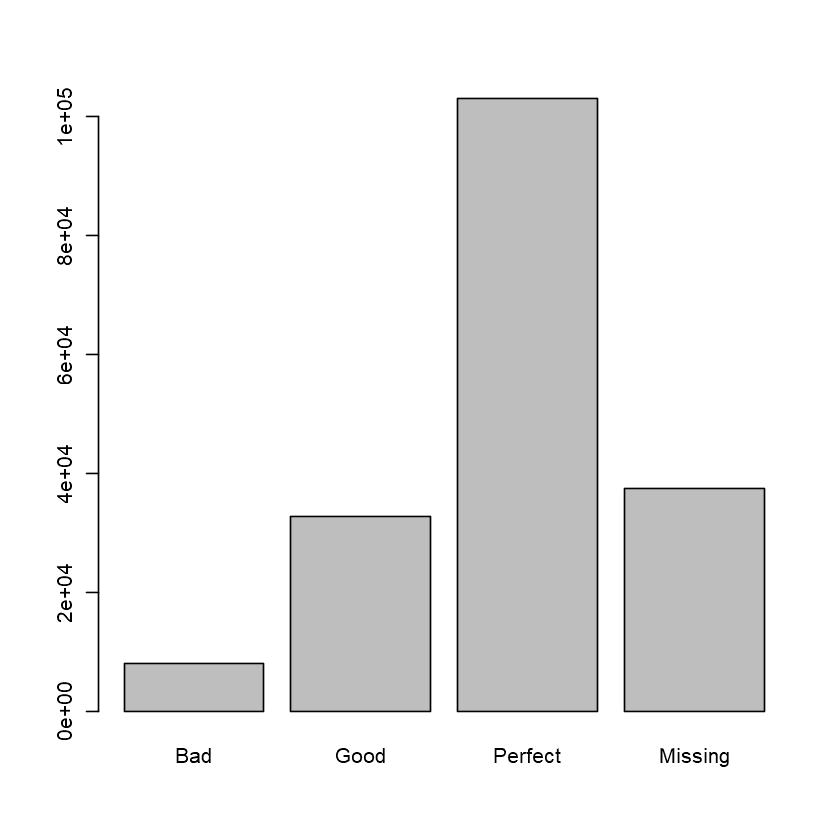

In [81]:
plot(df$review_scores_location)

## review_scores_value

In [82]:
summary(df$review_scores_value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.00    9.00    9.34   10.00   10.00   37519 

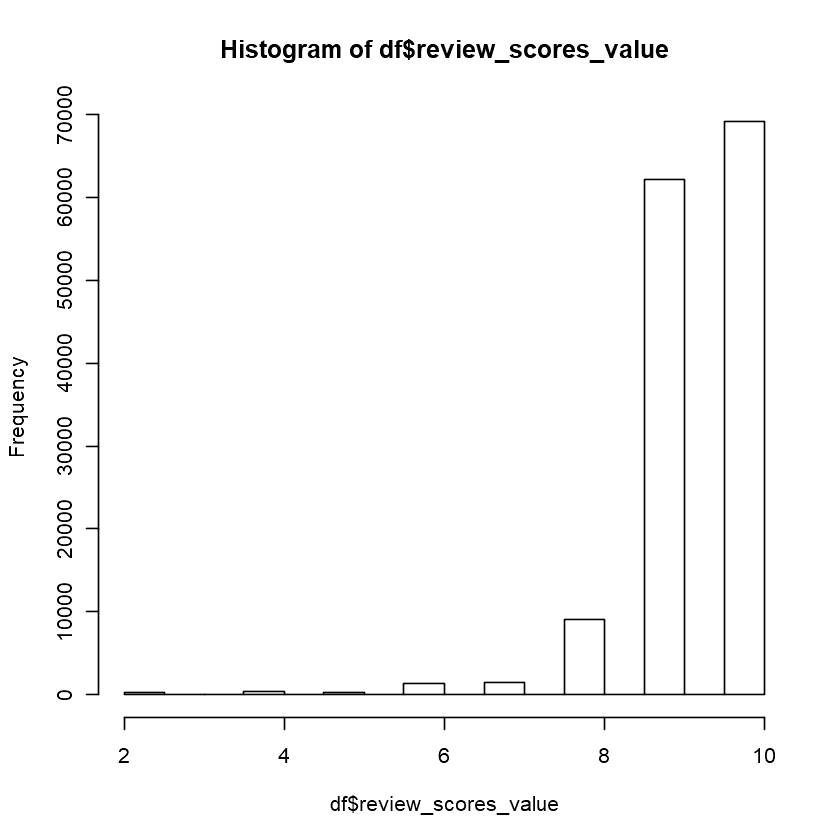

In [83]:
hist(df$review_scores_value)

In [84]:
# replace missing values by 11
df$review_scores_value[is.na(df$review_scores_value)] <- 11

# create a factors
df$review_scores_value<-cut(df$review_scores_value, c(0,9,10,11,12), labels = c("Bad", "Good", "Perfect", "Missing"), right = FALSE)

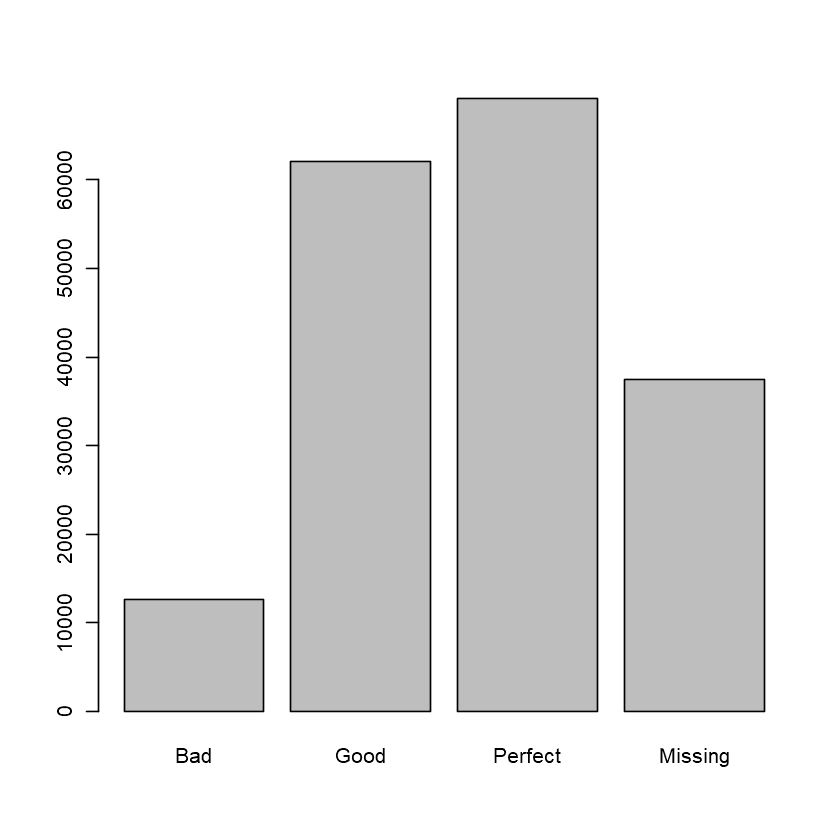

In [85]:
plot(df$review_scores_value)

## calculated_host_listings_count

In [86]:
summary(df$calculated_host_listings_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00   20.64   11.00  257.00 

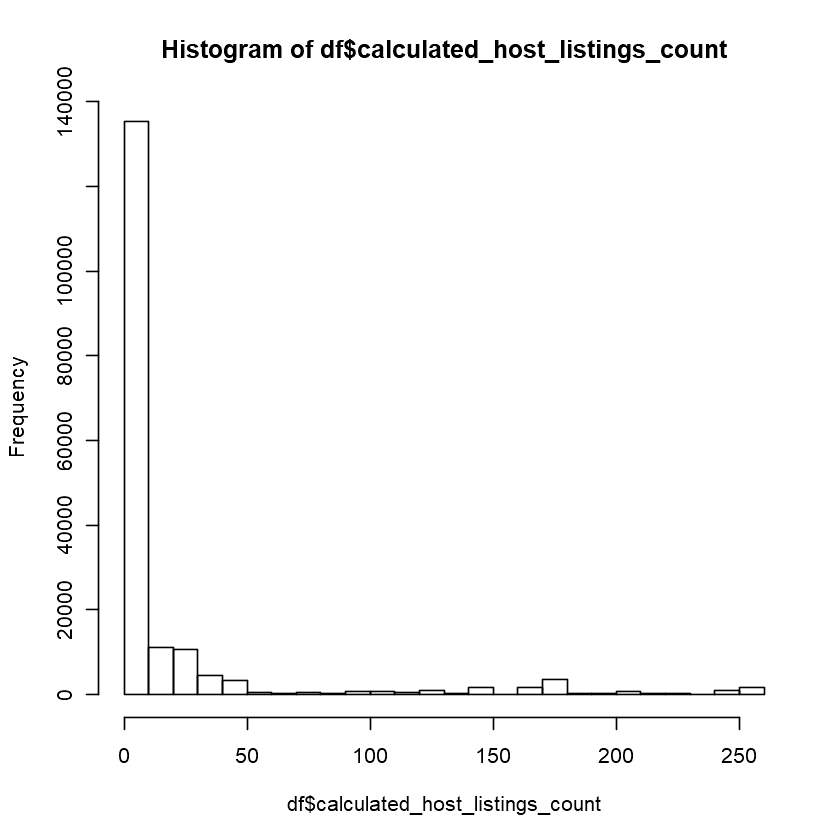

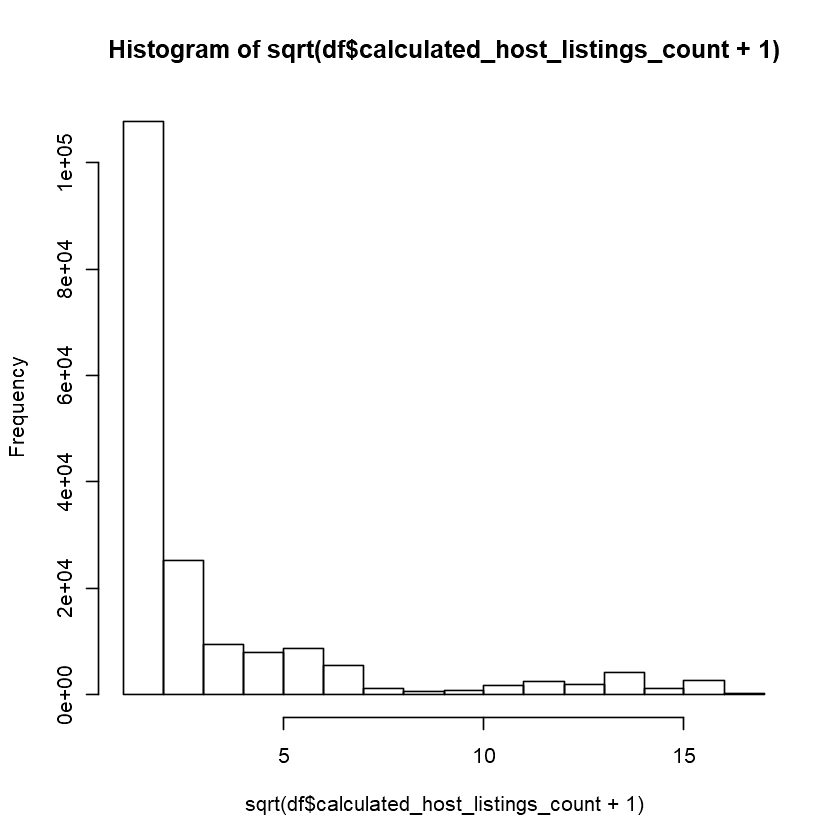

In [87]:
hist(df$calculated_host_listings_count)

hist(sqrt(df$calculated_host_listings_count + 1))

In [88]:
# convertin into factor
df$calculated_host_listings_count<-cut(df$calculated_host_listings_count, c(0,2, 5, 20, 50, 200, 300), 
          labels = c("Single", "upFive", "upTwenty", "upFifty", "upTwoHundred", "More"), 
          right = FALSE)

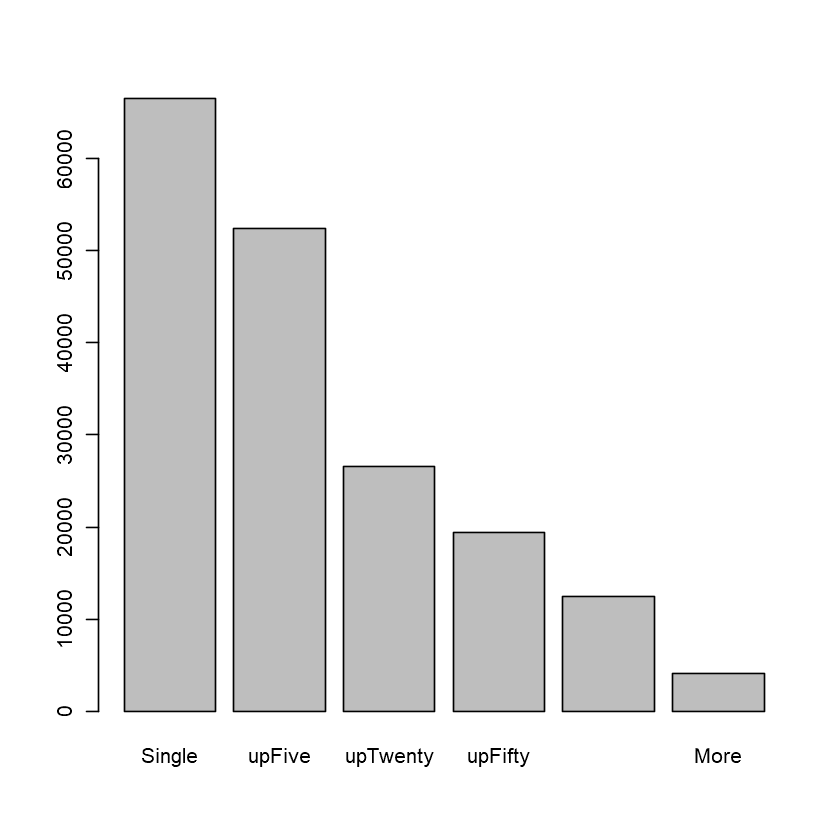

In [89]:
plot(df$calculated_host_listings_count)

## reviews_per_month

In [90]:
summary(df$reviews_per_month)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.01    0.56    1.54    2.17    3.21   42.82   36715 

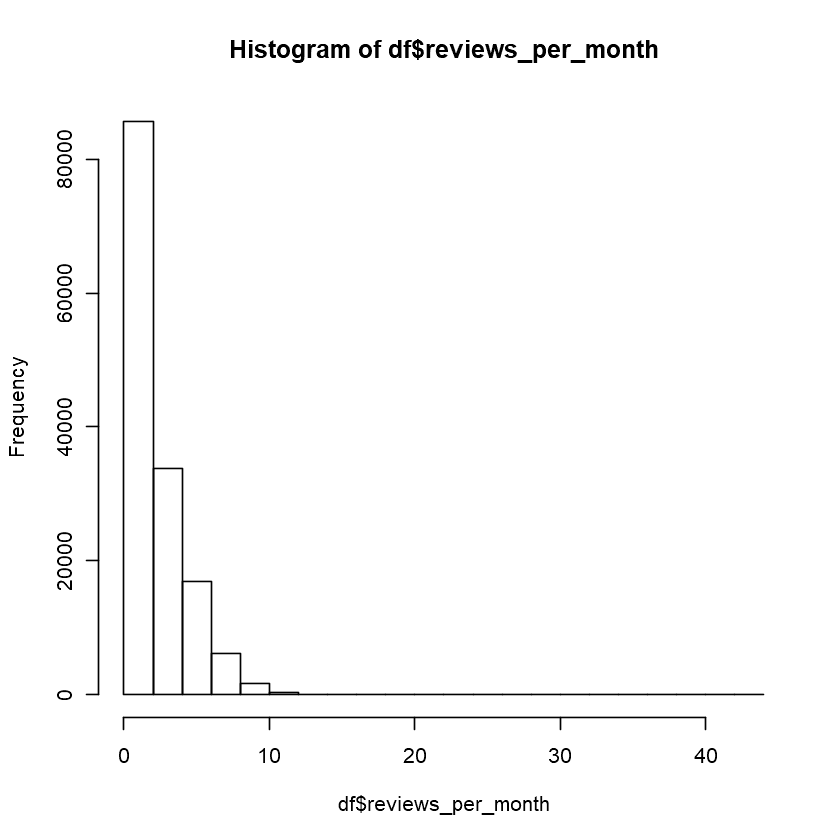

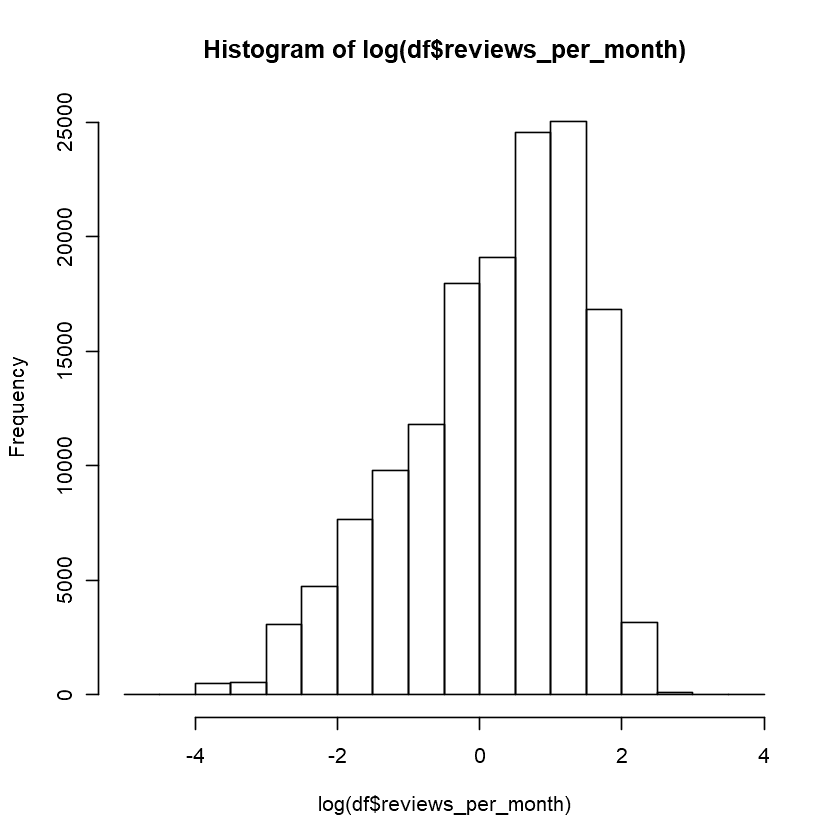

In [91]:
hist(df$reviews_per_month)

hist(log(df$reviews_per_month))

In [92]:
# replace missing values by 11
df$reviews_per_month[is.na(df$reviews_per_month)] <- 100
df$reviews_per_month<-cut(df$reviews_per_month, c(0:10,200), labels = c(1:10, "Missing"), right = FALSE)

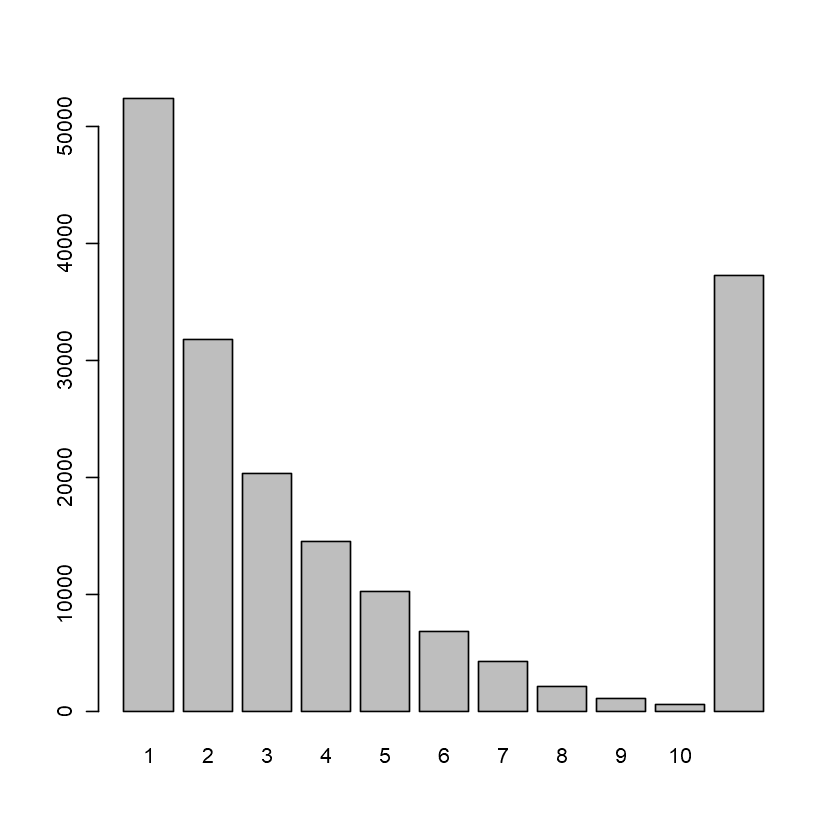

In [93]:
plot(df$reviews_per_month)

## host_seniority

In [94]:
summary(df$host_seniority)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   4.000   4.183   6.000 120.000 

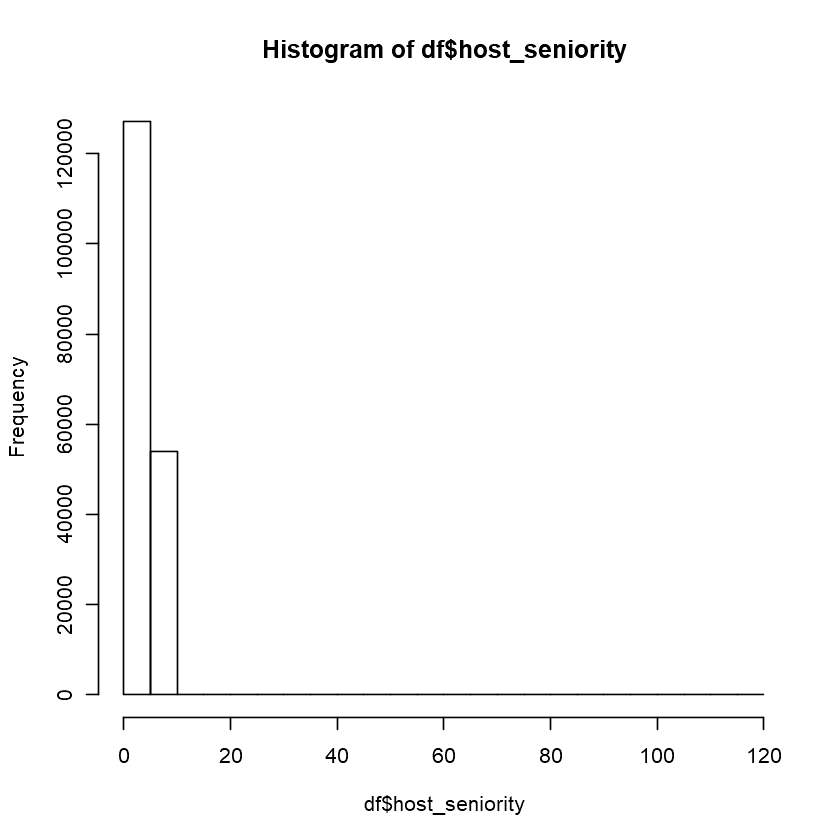

In [95]:
hist(df$host_seniority)

In [96]:
### removing values bigger than 20
df$host_seniority[df$host_seniority>20]<-NA

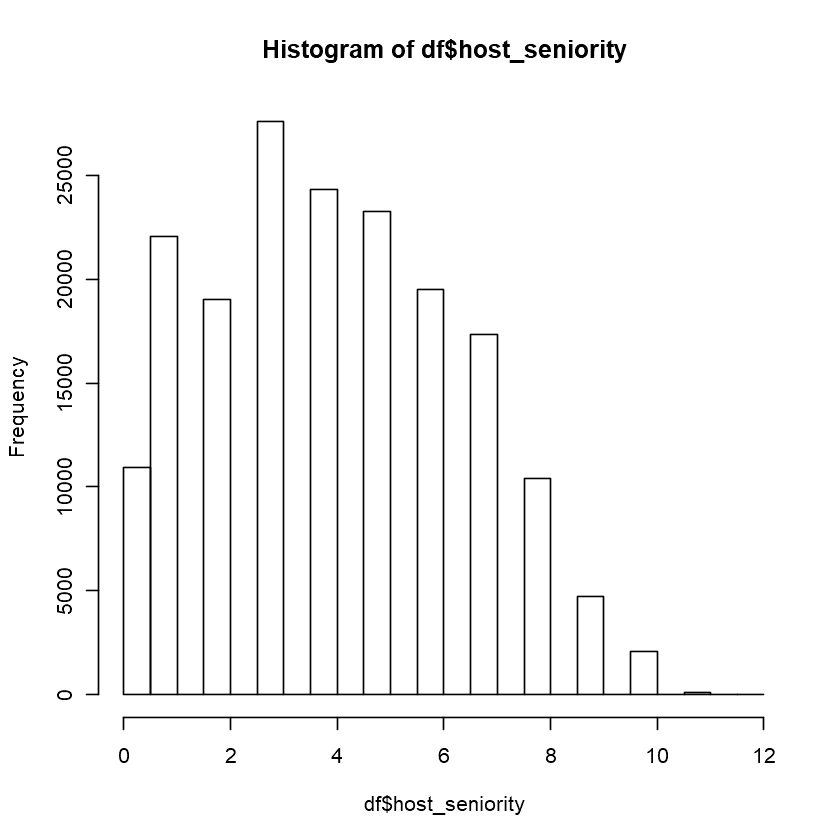

In [97]:
hist(df$host_seniority)

## Handle Missingness

[1] 181468     50

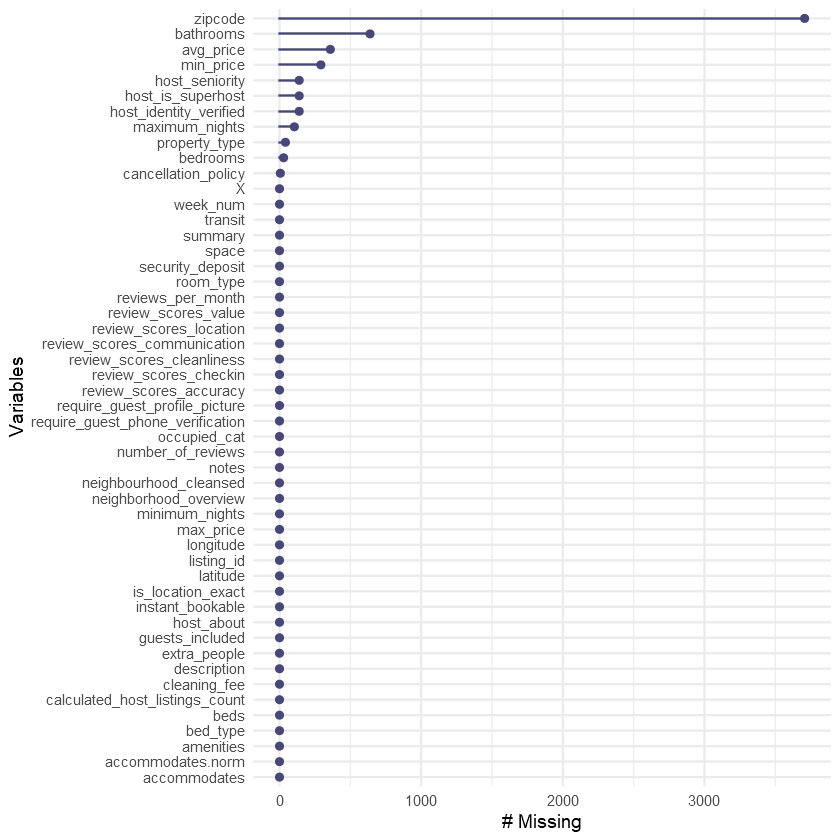

In [98]:
library(visdat)

dim(df)

gg_miss_var(df)

In [99]:
#add missing as another label
test<-addNA(df$zipcode, ifany = TRUE)

## Dataframe w/o missing value and outliers

In [100]:
mm <- mechkar::getMissingness(df,getRows=T)

dim(df)

df <- df[mm$rows,]

dim(df)

list(var = c(10, 17, 4, 5, 7, 8, 40, 26, 14, 18), na_count = c(3707, 639, 359, 292, 139, 139, 139, 105, 42, 29), rate = c(2, 0.4, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0, 0))This dataset has 176451 (97.2%) complete rows. Original data has 181468 rows.



[1] 181468     50

[1] 176451     50

In [101]:
exploreData(df[no.factors], y = 'occupied_cat', dir="c:\\bb\\airbnb\\data\\after_cleanising")

  |====================================================================  |  97%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  c:\bb\airbnb\data\after_cleanising\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

In [113]:
con<-file(filename_clean,encoding="UTF-8")

write.csv(df,file=con, row.names = FALSE)

save(df, file=gsub(".csv", ".RData", filename_clean))